In [62]:
import pandas as pd
import geopandas as gpd
import folium
import os
import sqlite3
import matplotlib.pylab as plt
from scipy import stats
import numpy as np
%config Completer.use_jedi = False #for auto complete code

In [234]:
#para el ttest pvalue debe ser mayor a 0.05 para aceptar de que son la misma muestra
def tables_in_sqlite_db(conn):
    cursor = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = [
        v[0] for v in cursor.fetchall()
        if v[0] != "sqlite_sequence"
    ]
    cursor.close()
    return tables

def gauge_stations(df,cuencas_shp,this_map,cuenca_name):
    geometry=cuencas_shp[cuencas_shp.NOMBRE==cuenca_name]['geometry']
    def add_geo(geometry,this_map):
        sim_geo=gpd.GeoSeries(geometry).simplify(tolerance=0.001)
        geo_j= sim_geo.to_json()
        geo_j=folium.GeoJson(data=geo_j,style_function=lambda x: {'fillColor':'orange'})
        geo_j.add_to(this_map)
        
    def plotDot(df):
        popup_name=df.NOMBRE_ESTACION+' '+df.CATEGORIA
        folium.CircleMarker(location=[df.LATITUD,df.LONGITUD],popup=popup_name,radius=2).add_to(this_map)
        
    add_geo(geometry,this_map)
    df.apply(plotDot, axis = 1)
    
    return this_map

def find_index_row(df,values,col):
    idx=[]
    for val in values:
        item=df.index[df[col] == val].tolist()[0]
        idx.append(item)
    return idx

def clean_outliers_internos(df):
    cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']
    outlier_inter_dict={}
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        outlier_upper=Q3 + 1.5 * IQR
        index_out=df[df[col]>outlier_upper].index.tolist()
        dates_out=df.loc[index_out,'Fecha Reg']
        outlier_inter_dict[col]=dates_out

    outlaiers_interno_df=pd.DataFrame(outlier_inter_dict)
    outlaiers_interno_solitarios=outlaiers_interno_df[outlaiers_interno_df.isnull().sum(axis=1)>2]

    for col in cols:
        elements_to_erase=find_index_row(df=df,col='Fecha Reg',values=outlaiers_interno_solitarios[col].dropna())
        df.loc[elements_to_erase,col]=np.NaN
        df.loc[df[col]<0,col]=np.NaN
        
    df[['Nivel Med']]=np.round(df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h']].mean(axis=1,skipna=True),2)
    
    return df

class Estacion:
    def __init__(self,database):
        self.database = database
        sql_query= "SELECT * FROM Maestro"
        self.Maestro = pd.read_sql(sql_query, conn)
        
        
        self.tables_clima={}
        

    def get_Maestro(self):
        return self.Maestro

    def estaciones_por_dz(self,num):
        self.tables_dz={}
        tables = tables_in_sqlite_db(self.database)
        filtro= self.Maestro[self.Maestro.DZ==num]
        name=list(filtro.NOMBRE_ESTACION+' '+filtro.CATEGORIA)
        
        for i,estacion in enumerate(filtro.CODIGO):
            estacion='T'+str(estacion)
            if estacion in tables:
                sql_query= "SELECT * FROM "+estacion
                df = pd.read_sql(sql_query, conn)
                df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
                df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']]=df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].apply(pd.to_numeric,errors='coerce')
                self.tables_dz[name[i]]=clean_outliers_internos(df)
                
        return self.tables_dz
    
    def estaciones_por_cuenca_dz(self,num):
        self.gauge_cuenca={}
        self.cod_gauge_cuenca={}
        
        tables = tables_in_sqlite_db(self.database)
        filtro= self.Maestro[self.Maestro.DZ==num]
        for cuenca in filtro.Cuenca:
            self.gauge_cuenca[cuenca]=[]
            self.cod_gauge_cuenca[cuenca]=[]
            
        cuencas=list(filtro.Cuenca)
        for i,estacion in enumerate(filtro.CODIGO):
            estacion_table='T'+str(estacion)
            if estacion_table in tables:
                cuenca=cuencas[i]
                sql_query= "SELECT * FROM "+estacion_table
                df=pd.read_sql(sql_query, conn)
                df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
                df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']]=df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].apply(pd.to_numeric,errors='coerce')
                self.gauge_cuenca[cuenca].append(df)
                self.cod_gauge_cuenca[cuenca].append(estacion)
            
        return (self.cod_gauge_cuenca,self.gauge_cuenca)
        
class Convencional(Estacion):
    def __init__(self,**kwargs):
        super(Convencional,self).__init__(**kwargs)
    
    def plot_dz_niveles(self):
        for estacion in self.tables_dz:
            df = self.tables_dz[estacion]
            df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
            df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']]=df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].apply(pd.to_numeric,errors='coerce')
            df.plot(x='Fecha Reg',y=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med'],figsize = (25,10),title=estacion)
        plt.show()
        
    def stats_dz_niveles(self):
        for estacion in self.tables_dz:
            df = self.tables_dz[estacion]
            print(estacion)
            print(df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']].describe())
    
    
    def max_historic_and_previous(self):
        self.stats_previous_historic=[]
        for estacion in self.tables_dz:
            df=self.tables_dz[estacion]
            df.columns=['Codigo','Estacion','Fecha Reg','ano','mes','dia','Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med','Caudal']
            
            cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']
            df[cols]=df[cols].apply(pd.to_numeric,errors='coerce')
            
            #Todos los anos presentes en la base de datos
            idx_years=pd.DatetimeIndex(df['Fecha Reg']).year
            years=np.unique(idx_years)
            if len(years)>=2:
                year0=years[0]
                previous_year=years[-2]
                present_year=years[-1]

                #year evaluation
                df_previous=df[idx_years==previous_year]
                df_historic=df[idx_years!=present_year]

                #month evaluation
                month_previous=pd.DatetimeIndex(df_previous['Fecha Reg']).month
                avenida_previous=(month_previous==1) | (month_previous==2) | (month_previous==3) | (month_previous==4)
                estiaje_previous=(month_previous==6) | (month_previous==7) | (month_previous==8) | (month_previous==9)

                month_historic = pd.DatetimeIndex(df_historic['Fecha Reg']).month
                avenida_historic=(month_historic==1) | (month_historic==2) | (month_historic==3) | (month_historic==4)
                estiaje_historic=(month_historic==6) | (month_historic==7) | (month_historic==8) | (month_historic==9)


                Estacion_niveles= [estacion+' '+col for col in cols]

                stats_df={}
                stats_df['Estaciones']=Estacion_niveles
                #stats_df['max año previo '+str(previous_year)]=list(df_previous[cols].max())
                #stats_df['max historico '+str(year0)+'-'+str(previous_year)]=list(df_historic[cols].max())
                
                stats_df['Año de Inicio']=list(np.repeat(year0,5))
                stats_df['Año de Fin']=list(np.repeat(present_year,5))
                stats_df['max año previo']=list(df_previous[cols].max())
                stats_df['max historico']=list(df_historic[cols].max())

                stats_df['max año previo estiaje']=df_previous[estiaje_previous][cols].max()
                stats_df['max año previo avenida']=df_previous[avenida_previous][cols].max()

                stats_df['max año historico estiaje']=list(df_historic[estiaje_historic][cols].max())
                stats_df['max año historico avenida']=list(df_historic[avenida_historic][cols].max())
                self.stats_previous_historic.append(pd.DataFrame(stats_df))
            else:
                print(estacion+ 'tiene menos de dos años de registro '+str(years))        
        return self.stats_previous_historic
    
# Las fechas de outliers que por lo menos no tenga una estacion vecina que lo confirme se elimino
# debe haber un control interno y de vecinos inicialmente
    
class Automatica(Estacion):
    pass

      

In [235]:
conn = sqlite3.connect('../data/DZ/niveles.db')
cuencas_shp=gpd.read_file('../data/shp/cuencas/UH.shp')
Estacion_convencional=Convencional(database=conn)

In [236]:
Estacion_convencional.get_Maestro().head(10)

INVENTARIO_SINCERADO  DZ          NOMBRE_ESTACION    CODIGO     CATEGORIA  \
0                   NO   1                CABO_INGA  47E01126    AUTOMATICA   
1                   NO   1                 EL_TIGRE    200202  CONVENCIONAL   
2                   NO   1                 EL_TIGRE  4724A3F6    AUTOMATICA   
3                   NO   1            PUENTE_TUMBES  47E024BC    AUTOMATICA   
4                   NO  13  PUENTE_LOROCO_CALLACAME    210502  CONVENCIONAL   
5                   NO  13         PUENTE_ZAPATILLA    270503  CONVENCIONAL   
6                   SI  13                   ENAFER  47256412    AUTOMATICA   
7                   NO  13                   ENAFER    270000  CONVENCIONAL   
8                   NO  13         PUENTE_CARRETERA  47251282    AUTOMATICA   
9                   NO  13             PUENTE_RAMIS    210101  CONVENCIONAL   

  CLASIFICACION                TIPO    COMUNICACION FECHA_DE_INSTALACION  \
0           EHA         HIDROLÓGICA  SATELITAL GOES             05/12/14   
1           HLG         HIDROLÓGICA      VOZ Y DATA             01/08/64   
2          EHMA  HIDROMETEOROLÓGICA  SATELITAL GOES             11/08/01   
3           EHA         HIDROLÓGICA  SATELITAL GOES             22/10/14   
4           HLG         HIDROLÓGICA      VOZ Y DATA             09/07/94   
5           HLM         HIDROLÓGICA      VOZ Y DATA             01/01/76   
6           EHA         HIDROLÓGICA  SATELITAL GOES             SIN_DATO   
7           HLM         HIDROLÓGICA         NINGUNO             01/03/08   
8           EHA         HIDROLÓGICA  SATELITAL GOES             30/12/00   
9           HLG         HIDROLÓGICA      VOZ Y DATA             01/01/56   

  ESTADO_FUNCIONAMIENTO  ...    LATITUD   LONGITUD  Lat_Sexagesimal  \
0           FUNCIONANDO  ...  -3.978733 -80.399381     -3°58'43.44"   
1           FUNCIONANDO  ...  -3.768480 -80.456850      -3°46'6.53"   
2           FUNCIONANDO  ...  -3.768700 -80.456889      -3°46'7.32"   
3           FUNCIONANDO  ...  -3.570878 -80.460872     -3°34'15.16"   
4           FUNCIONANDO  ... -16.570650 -69.322780    -16°34'14.34"   
5           FUNCIONANDO  ... -16.138603 -69.578730     -16°8'18.97"   
6           FUNCIONANDO  ... -15.836493 -70.016030    -15°50'11.37"   
7            PARALIZADA  ... -15.836490 -70.015898    -15°50'11.36"   
8           FUNCIONANDO  ... -15.255309 -69.873786    -15°15'19.11"   
9           FUNCIONANDO  ... -15.255309 -69.873786    -15°15'19.11"   

  Lot_Sexagesimal ALTITUD  DEPARTAMENTO  PROVINCIA     DISTRITO     COD_Clima  \
0   -80°23'57.77"   160.0        TUMBES     TUMBES  SAN JACINTO  C (i , p) A'   
1   -80°27'24.66"    36.0        TUMBES     TUMBES  SAN JACINTO  D (i , p) A'   
2    -80°27'24.8"    37.0        TUMBES     TUMBES  SAN JACINTO  D (i , p) A'   
3   -80°27'39.14"     8.0        TUMBES     TUMBES       TUMBES  D (i , p) A'   
4   -69°19'22.01"  3862.0          PUNO   CHUCUITO      KELLUYO  C (o , i) C'   
5   -69°34'43.43"  3846.0          PUNO  EL COLLAO        ILAVE  C (o , i) C'   
6    -70°0'57.71"  3812.0          PUNO       PUNO         PUNO  B (o , i) C'   
7    -70°0'57.23"  3823.0          PUNO       PUNO         PUNO  B (o , i) C'   
8   -69°52'25.63"  3825.0          PUNO   HUANCANE       TARACO  C (o , i) C'   
9   -69°52'25.63"  3825.0          PUNO   HUANCANE       TARACO  C (o , i) C'   

              Cuenca  
0      Cuenca Tumbes  
1      Cuenca Tumbes  
2      Cuenca Tumbes  
3      Cuenca Tumbes  
4  Cuenca Callaccame  
5   Intercuenca 0157  
6   Intercuenca 0173  
7   Intercuenca 0173  
8  Intercuenca Ramis  
9  Intercuenca Ramis  

[10 rows x 21 columns]

# Estaciones de la DZ 4

C:\Users\jose\anaconda3\envs\work_env\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


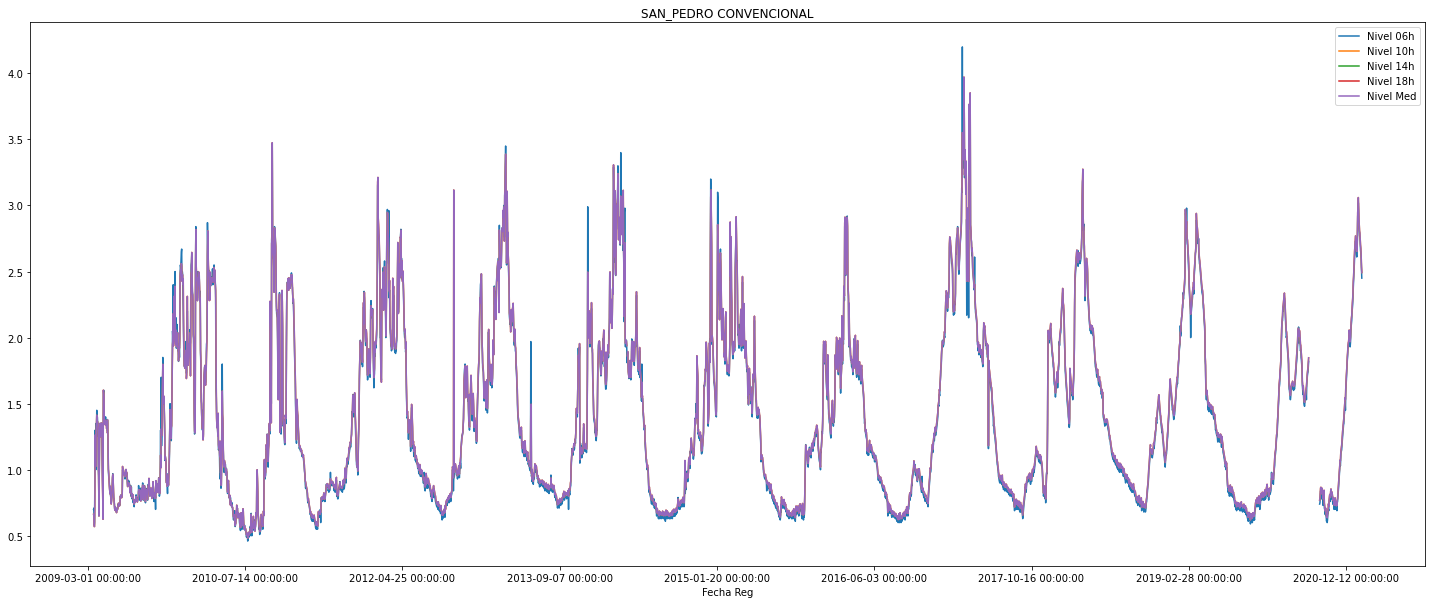

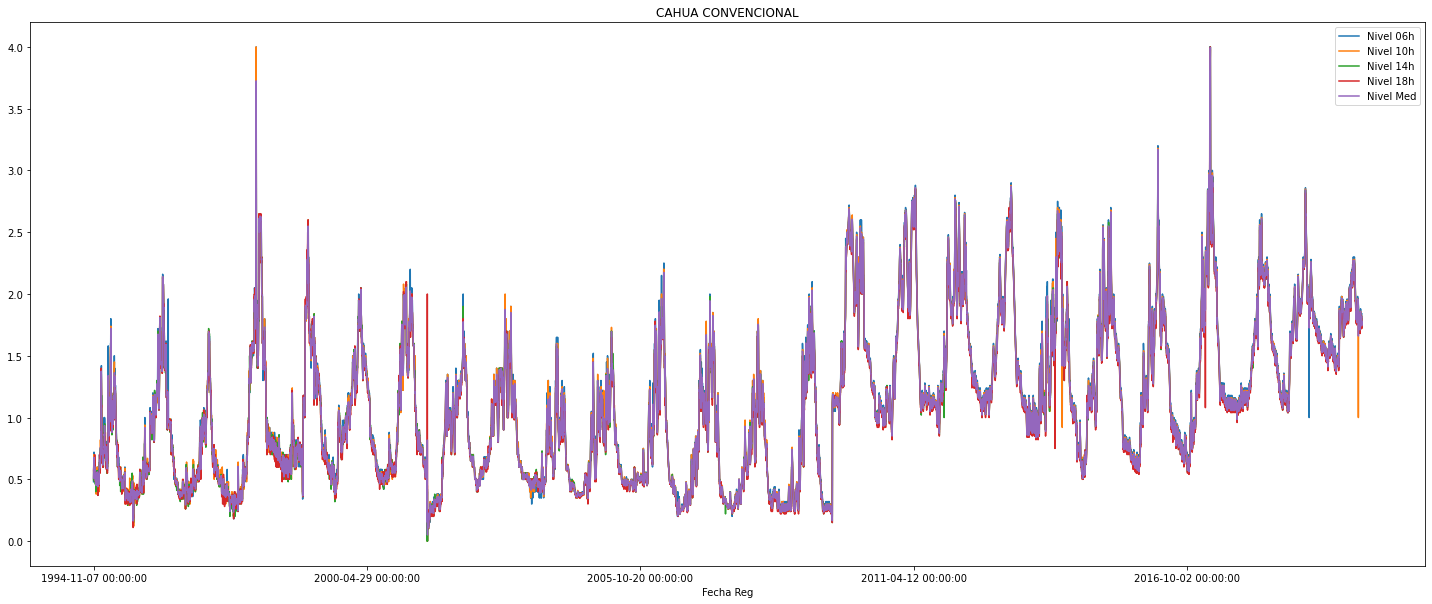

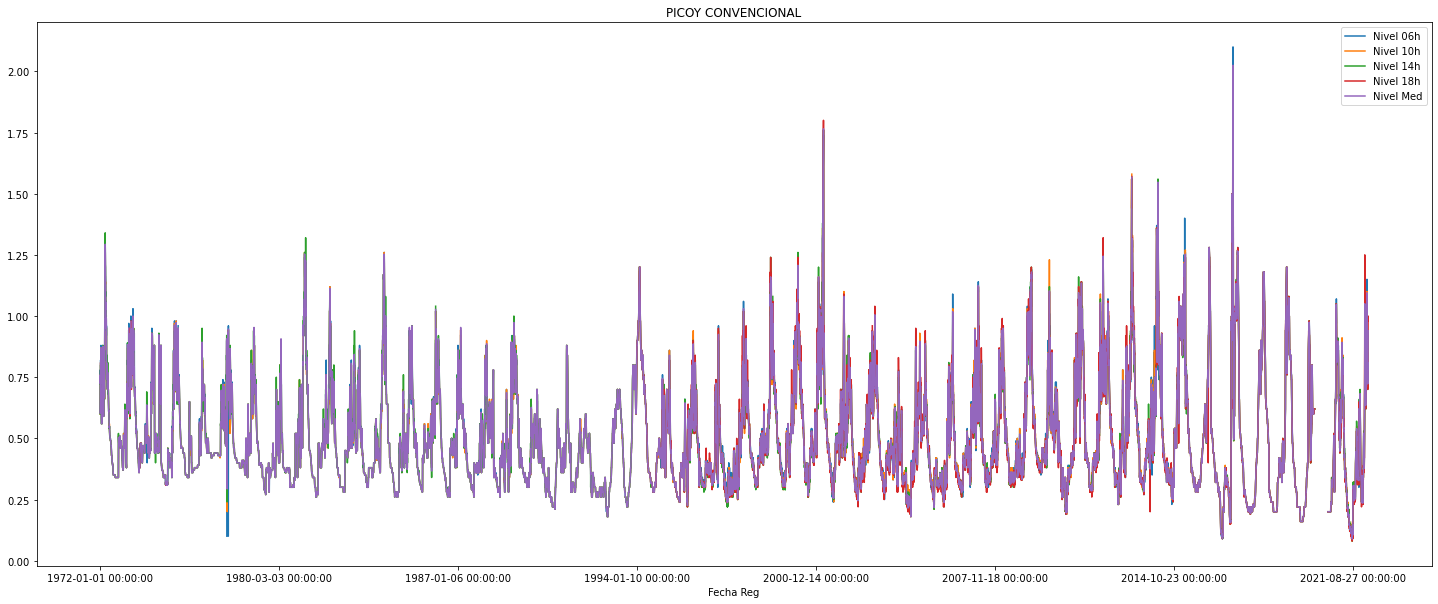

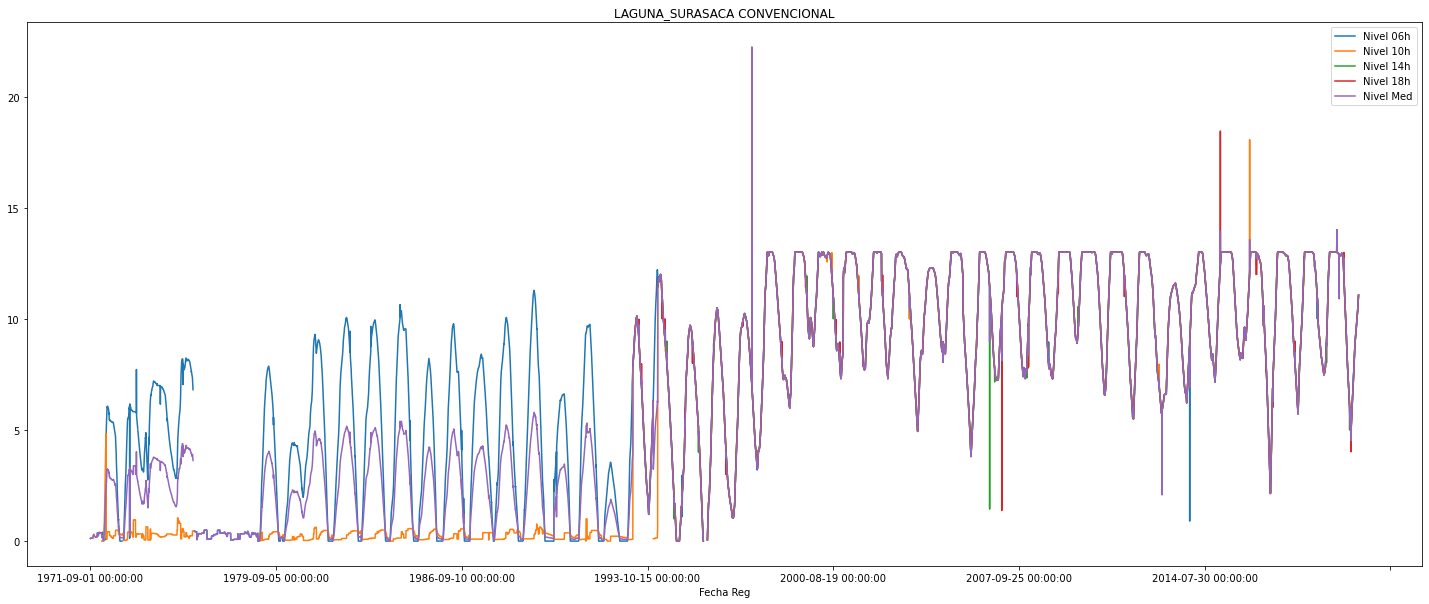

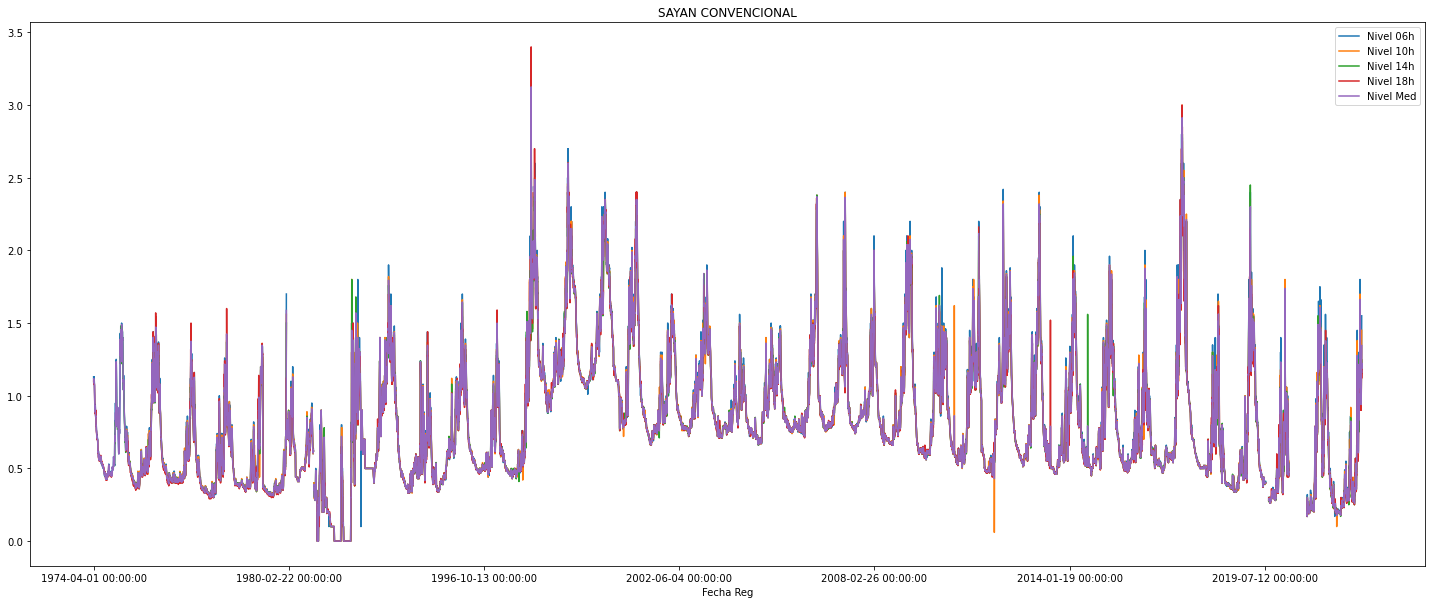

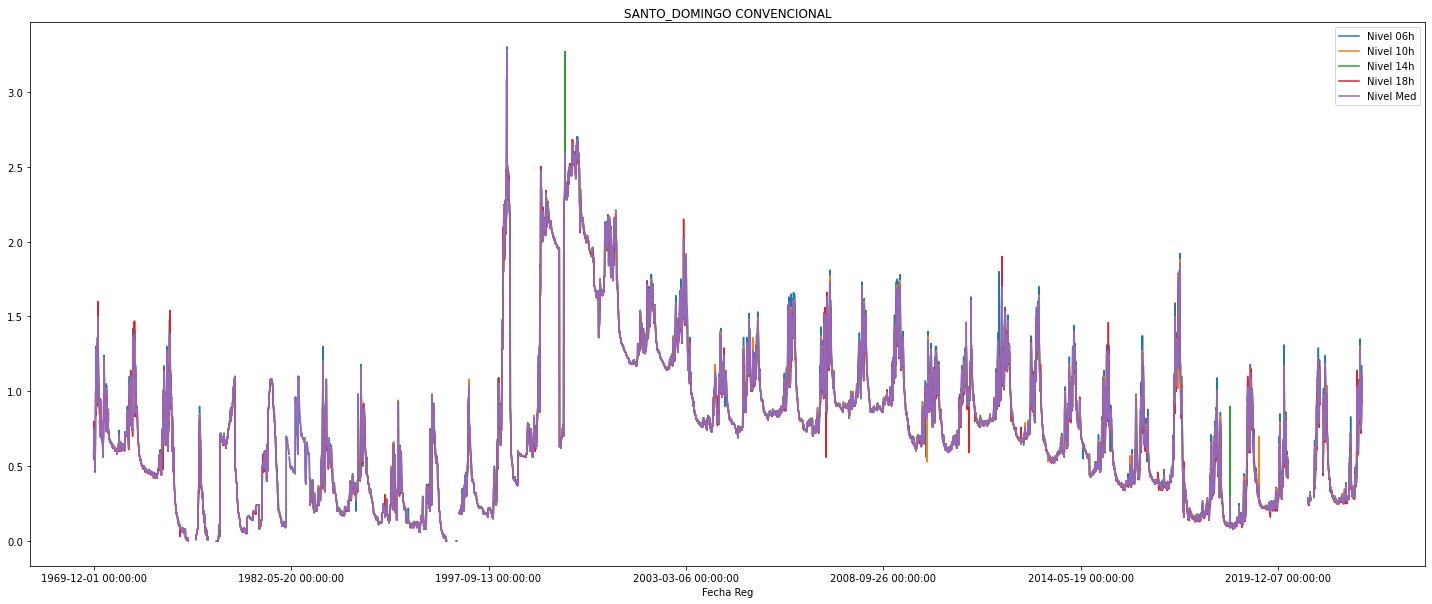

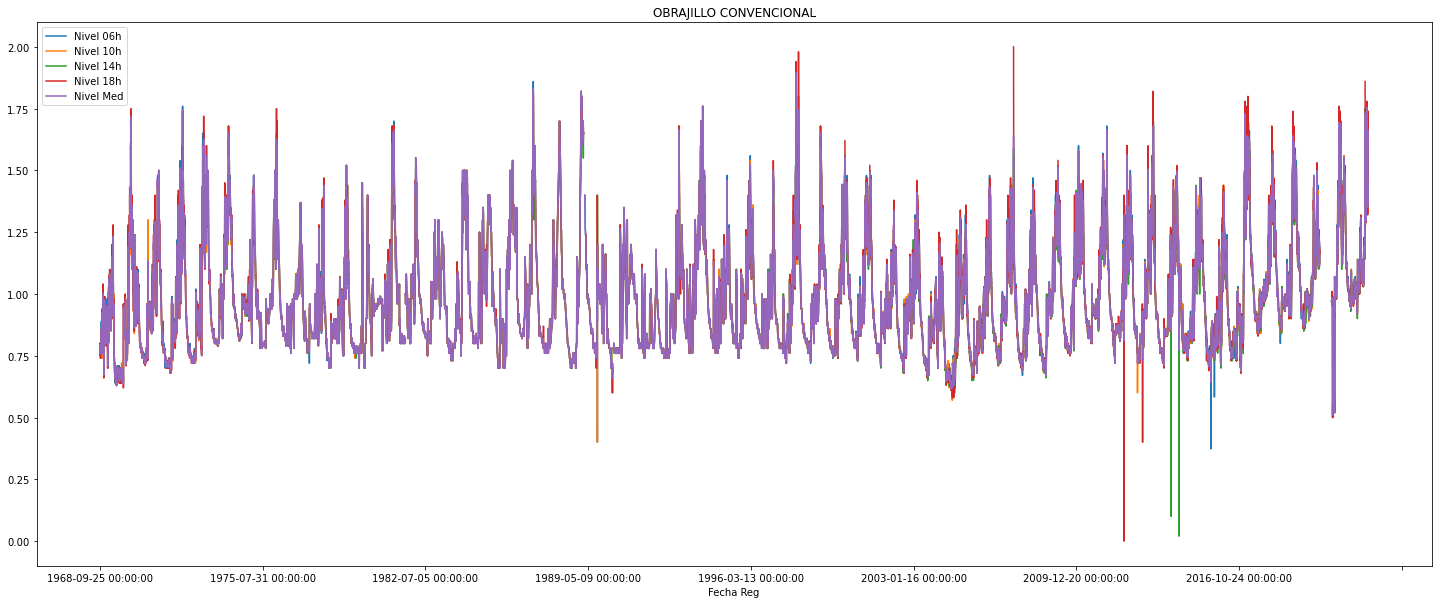

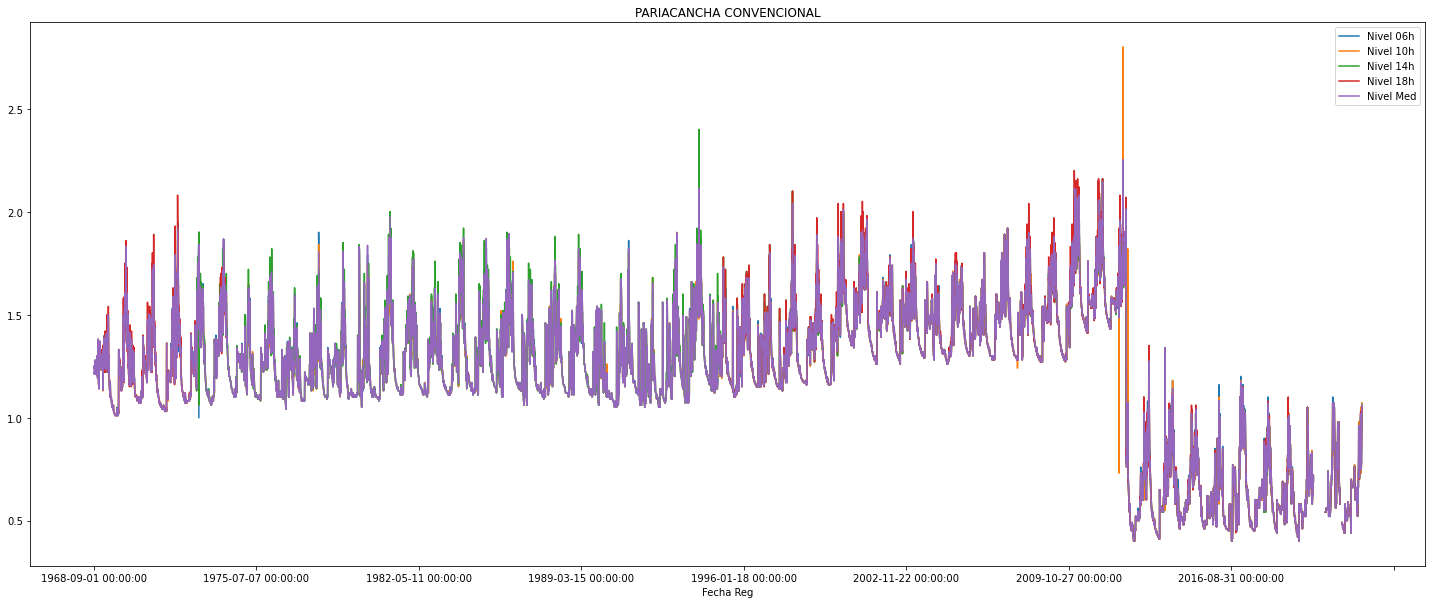

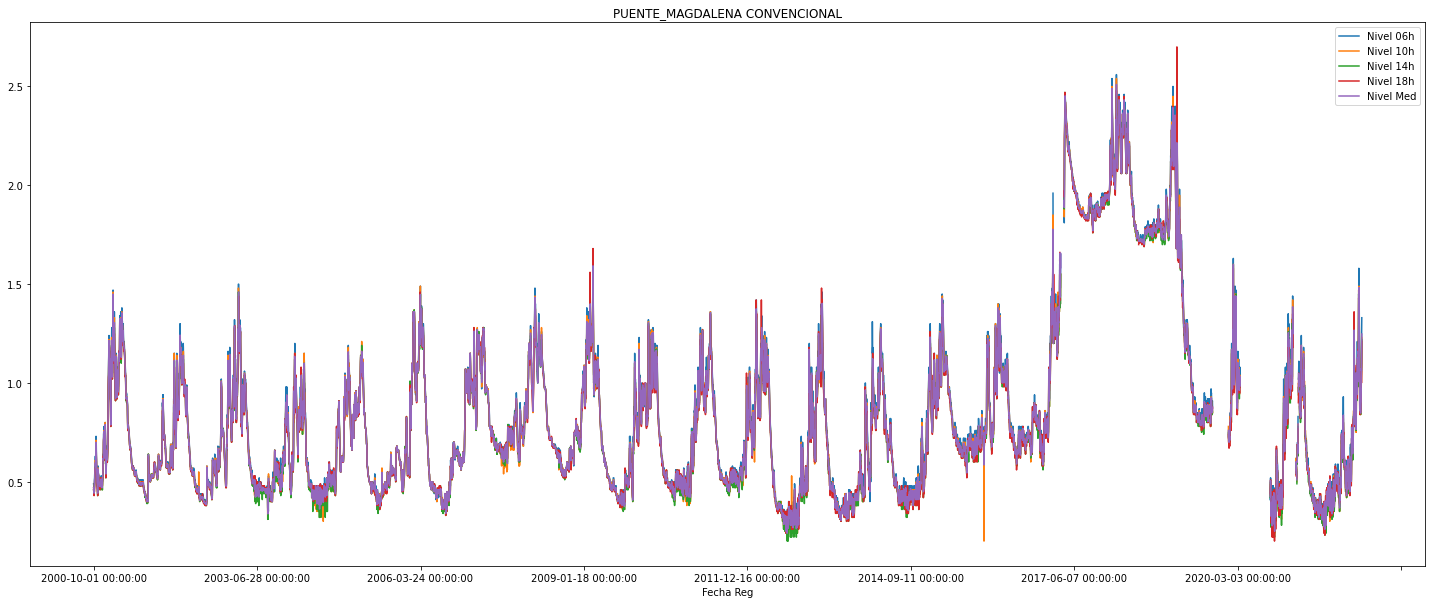

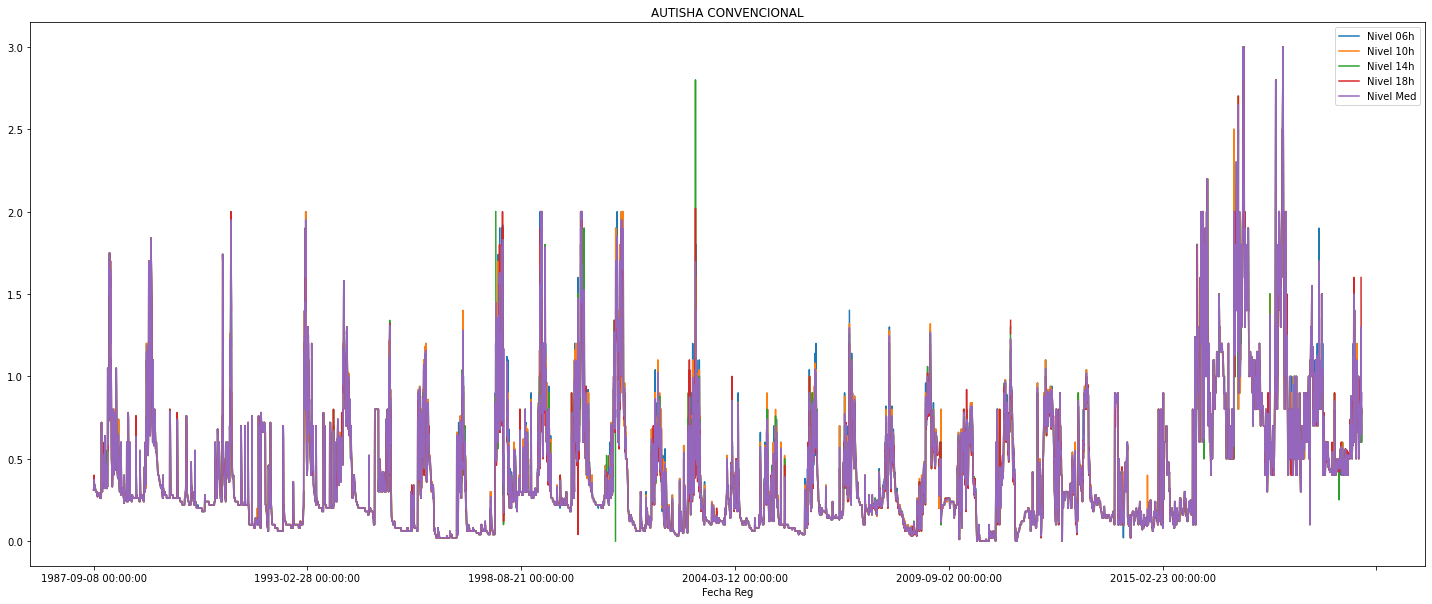

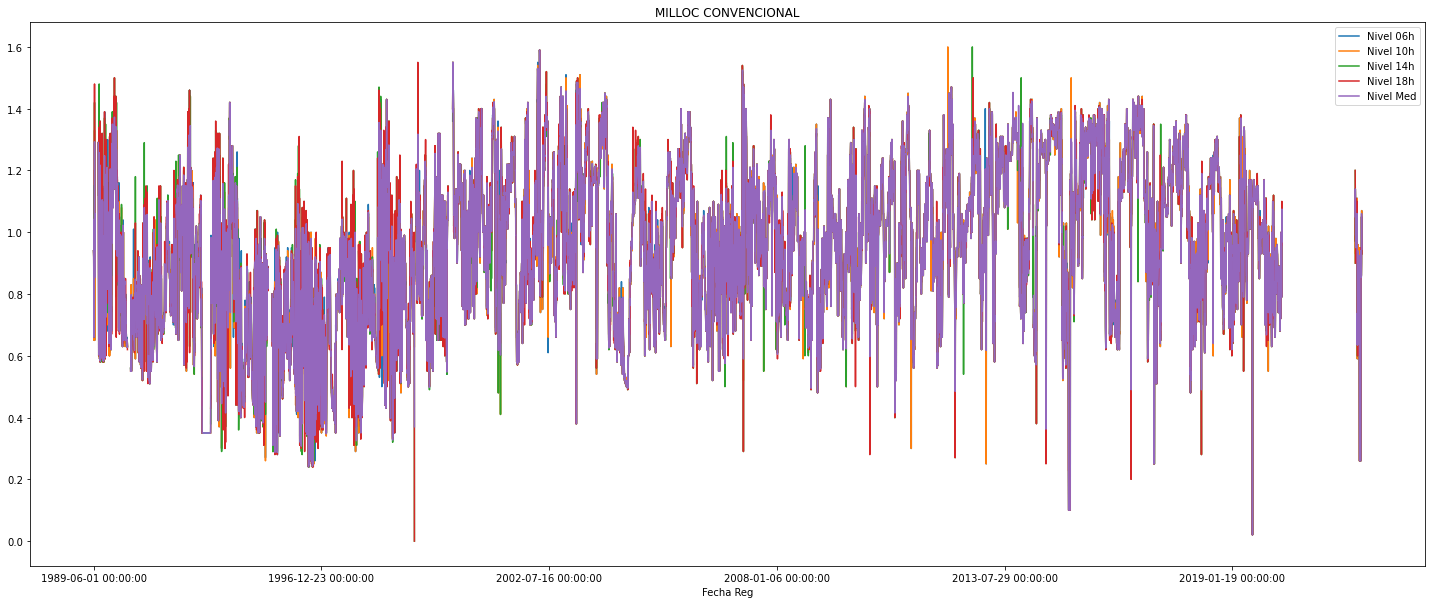

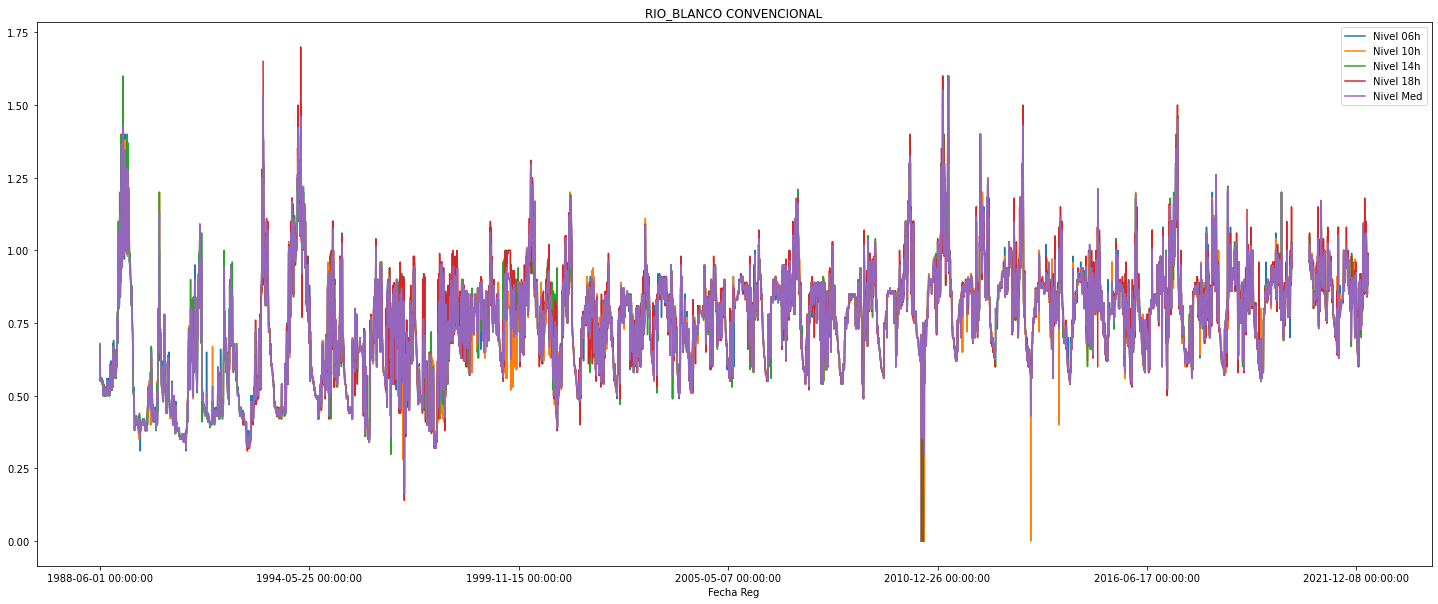

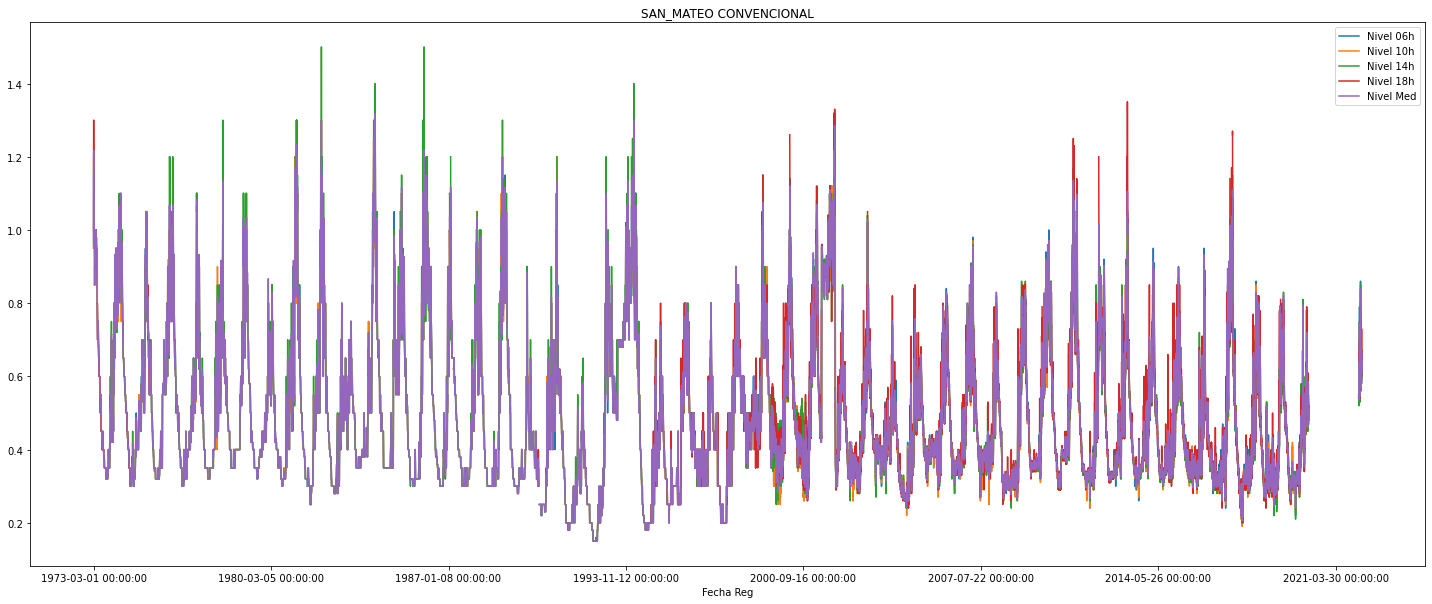

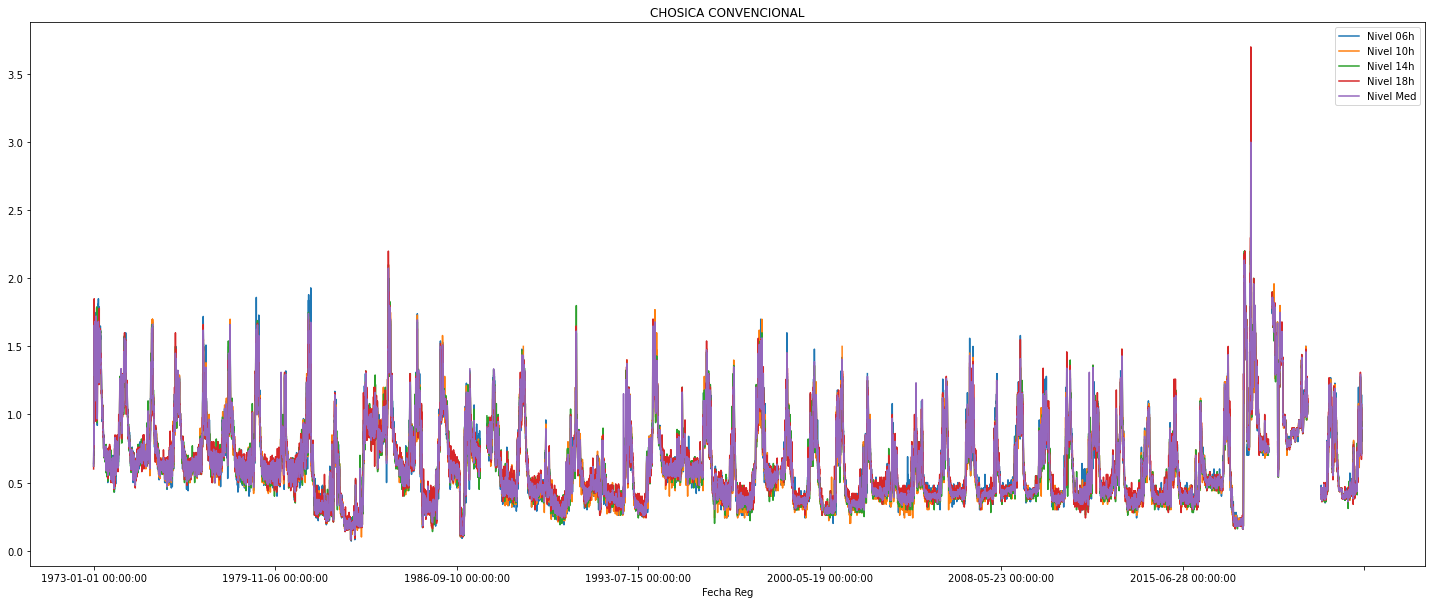

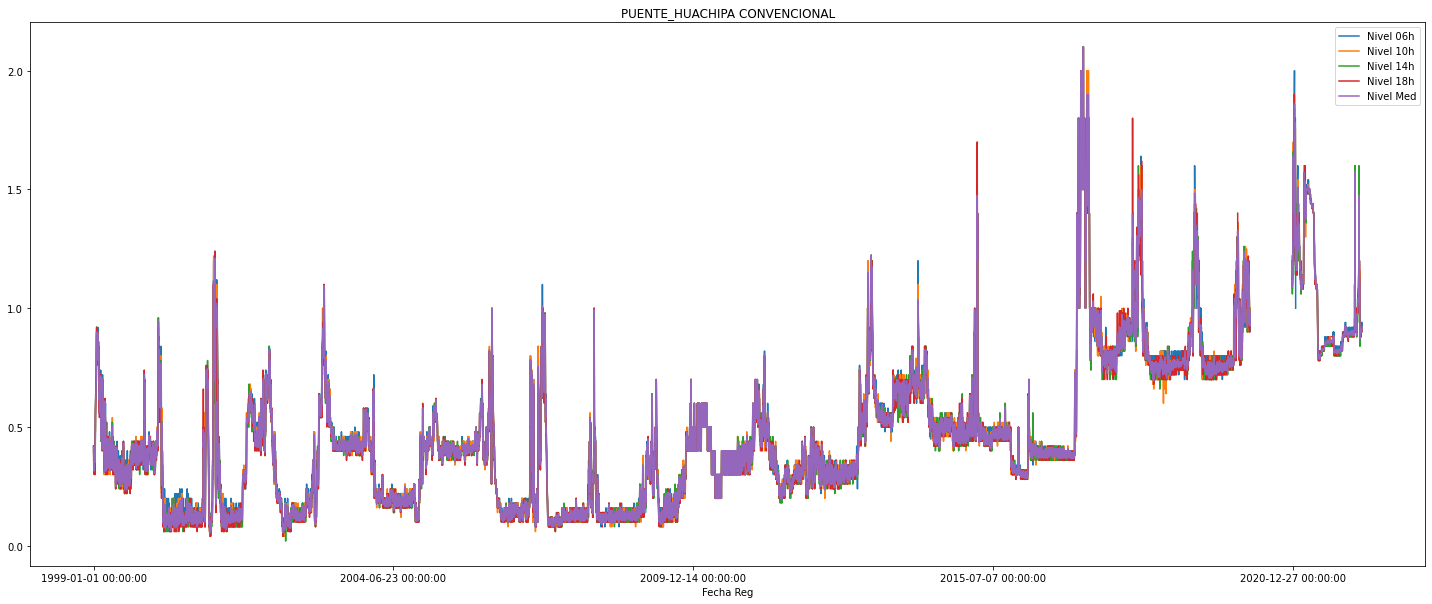

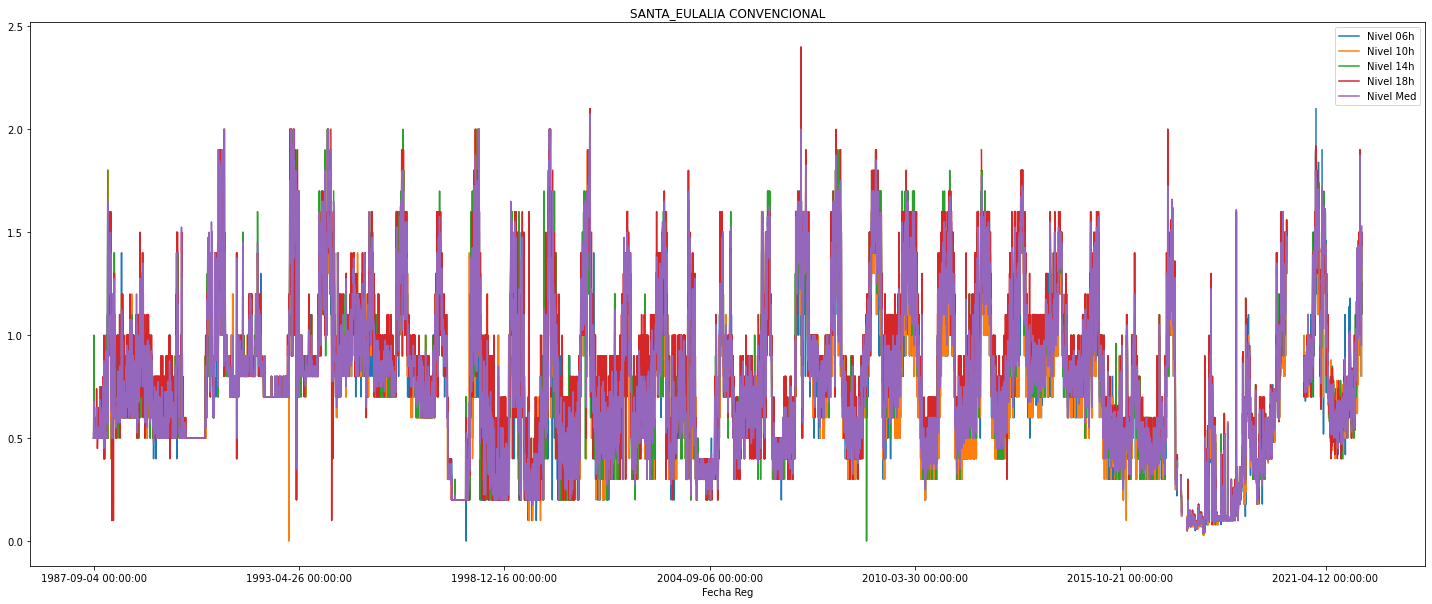

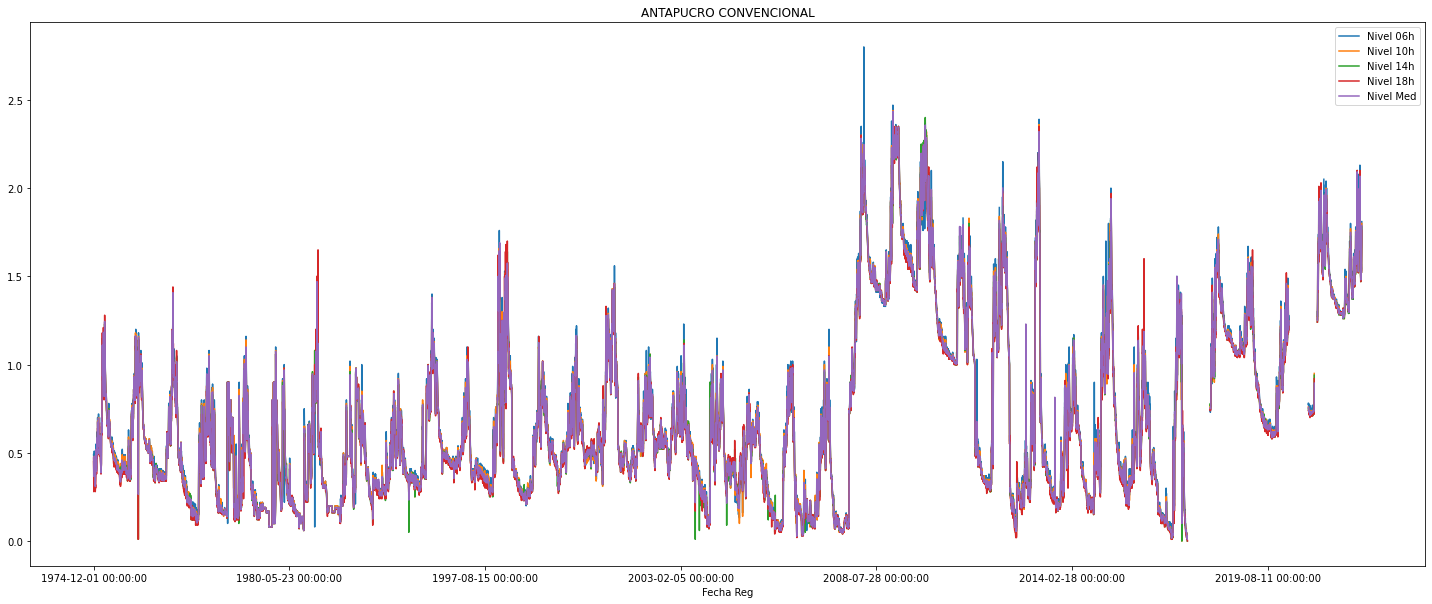

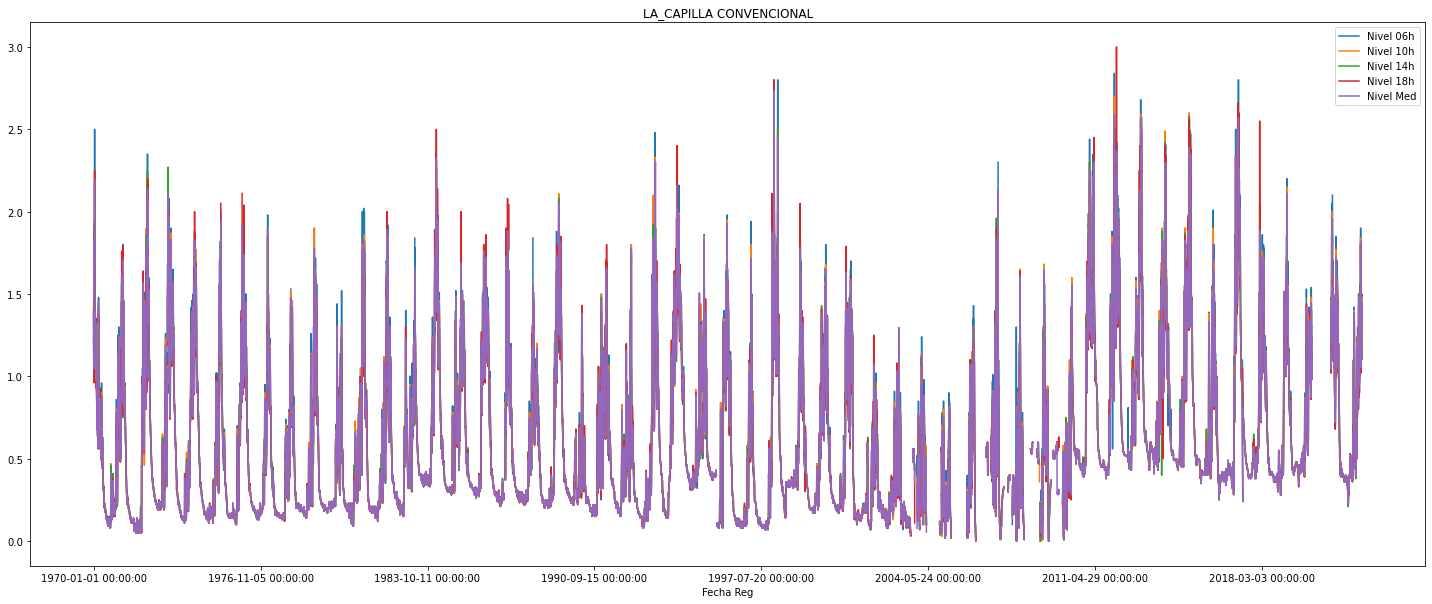

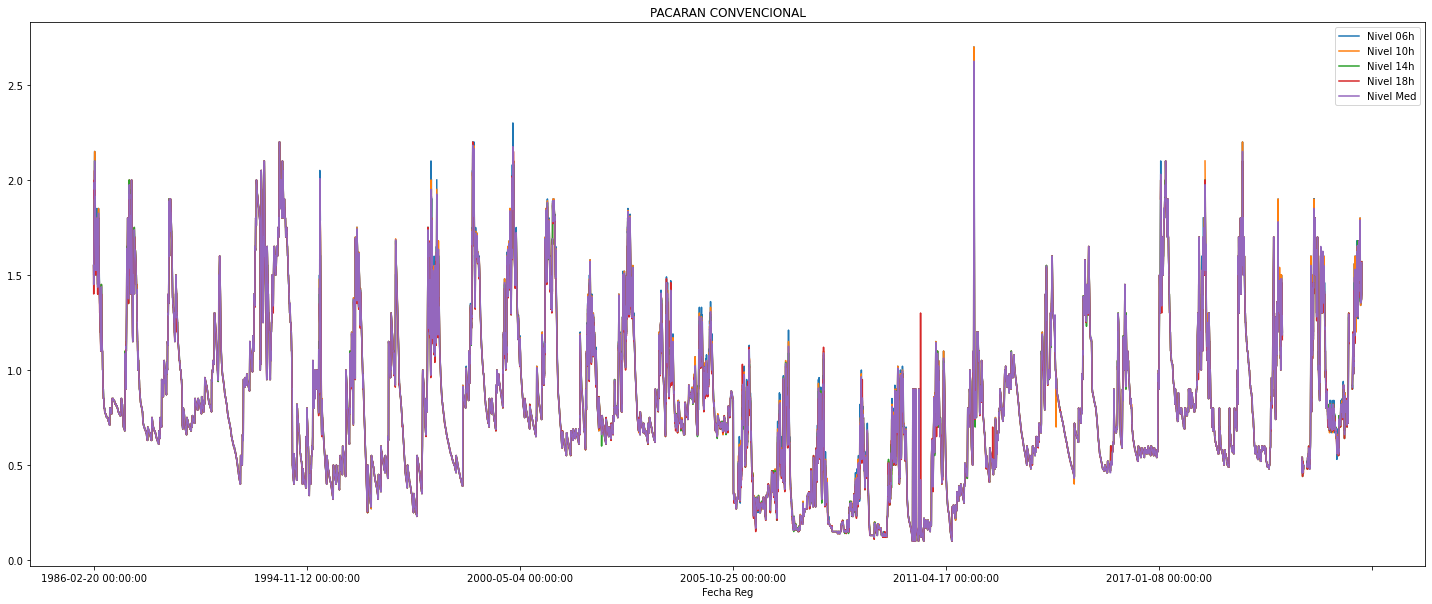

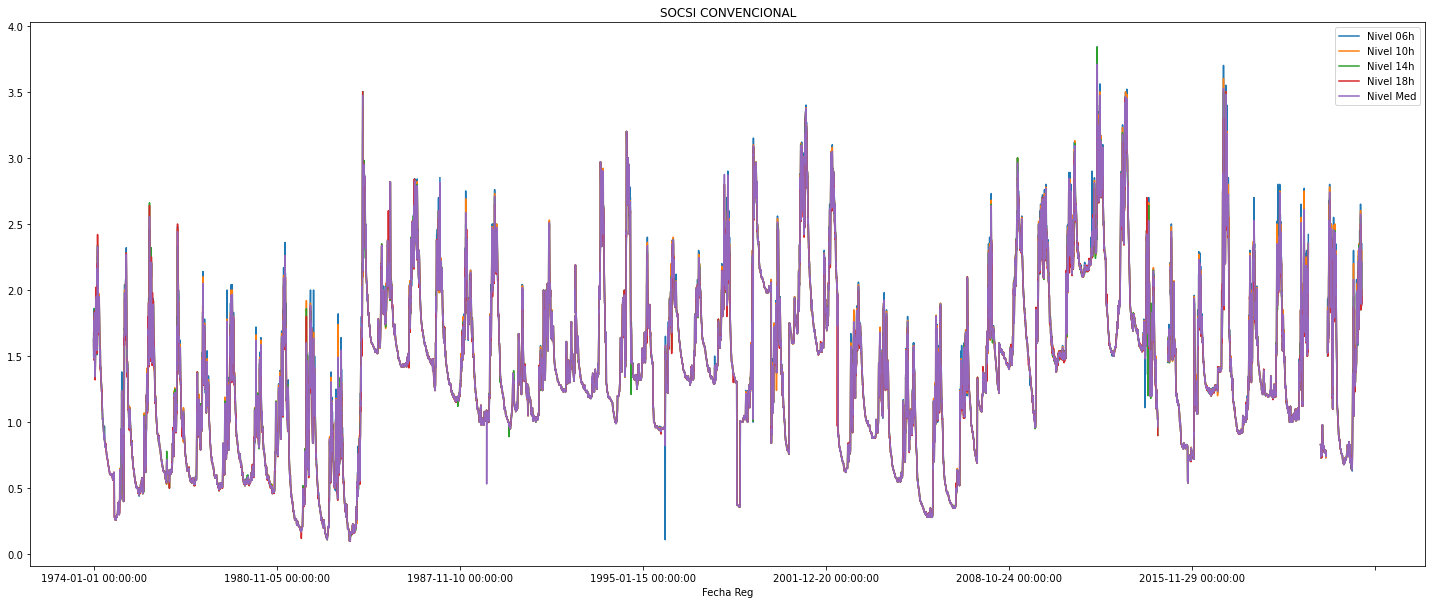

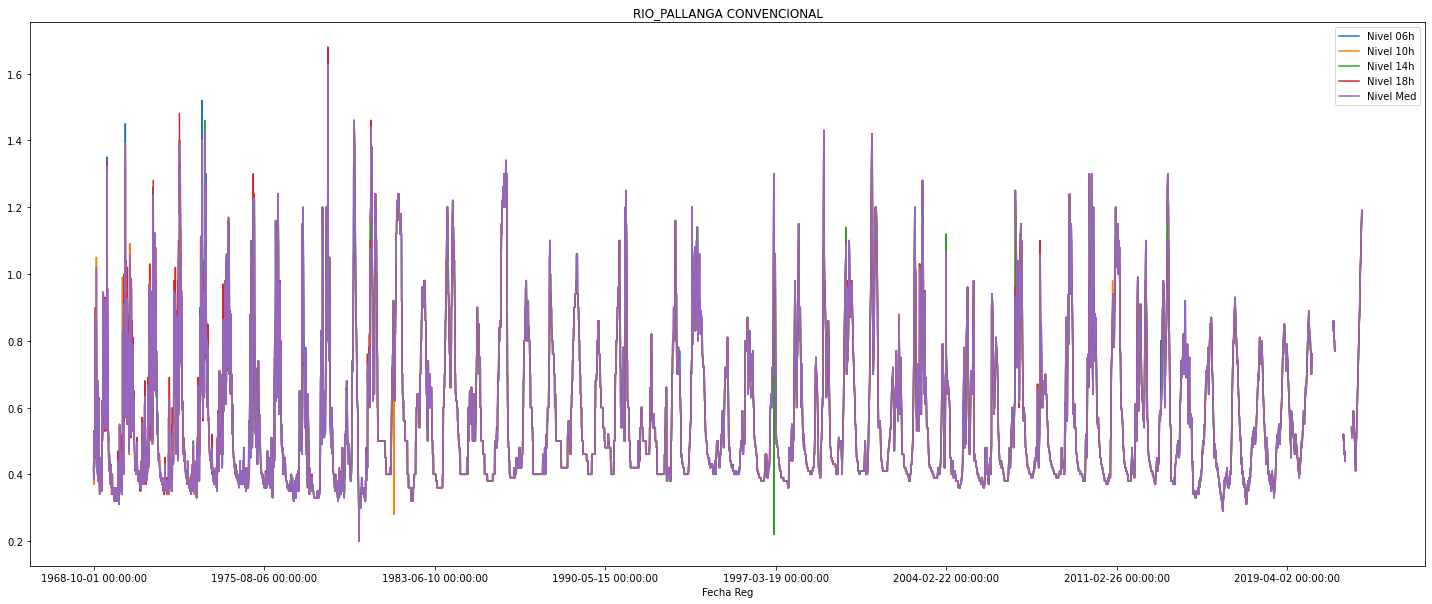

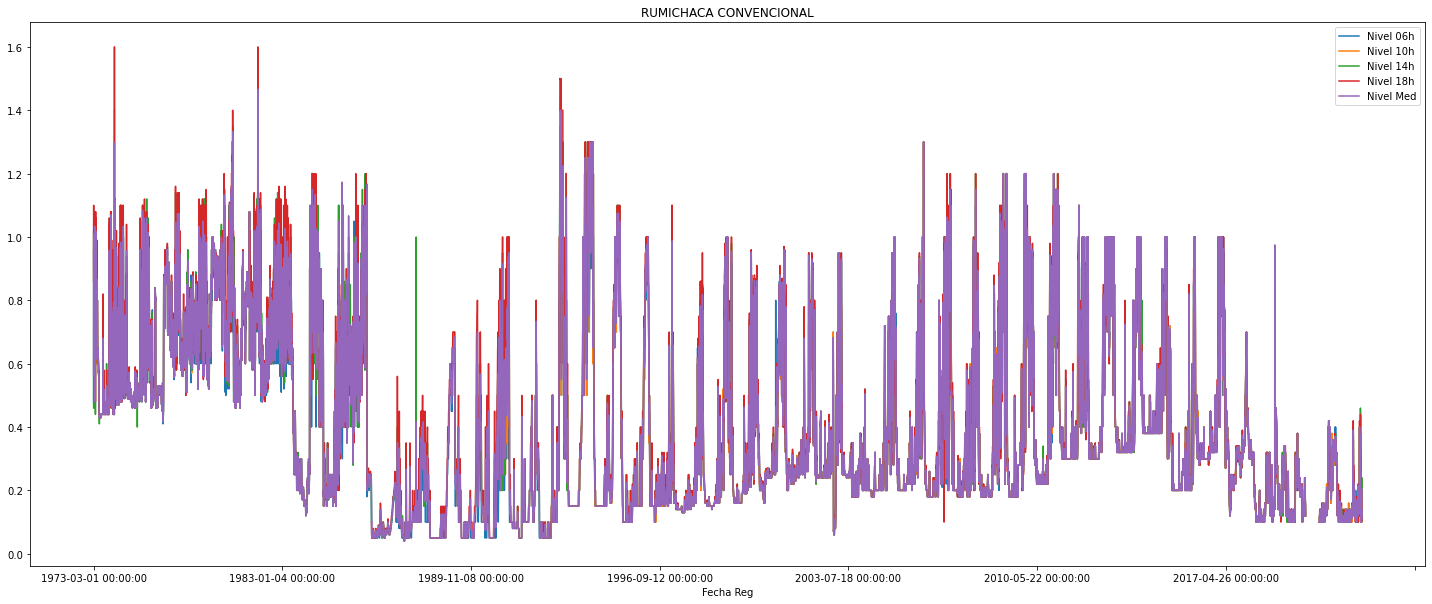

In [237]:
DZ4=Estacion_convencional.estaciones_por_dz(4)
Estacion_convencional.plot_dz_niveles()

In [67]:
#Estacion_convencional.stats_dz_niveles()

In [239]:
Estadisticos=pd.concat(Estacion_convencional.max_historic_and_previous())
Estadisticos.to_excel('../data/horizontes/Estadisticos.xlsx',index=False)
Estadisticos.head(20)

Estaciones  Año de Inicio  Año de Fin  \
Nivel 06h        SAN_PEDRO CONVENCIONAL Nivel 06h           2009        2021   
Nivel 10h        SAN_PEDRO CONVENCIONAL Nivel 10h           2009        2021   
Nivel 14h        SAN_PEDRO CONVENCIONAL Nivel 14h           2009        2021   
Nivel 18h        SAN_PEDRO CONVENCIONAL Nivel 18h           2009        2021   
Nivel Med        SAN_PEDRO CONVENCIONAL Nivel Med           2009        2021   
Nivel 06h            CAHUA CONVENCIONAL Nivel 06h           1994        2020   
Nivel 10h            CAHUA CONVENCIONAL Nivel 10h           1994        2020   
Nivel 14h            CAHUA CONVENCIONAL Nivel 14h           1994        2020   
Nivel 18h            CAHUA CONVENCIONAL Nivel 18h           1994        2020   
Nivel Med            CAHUA CONVENCIONAL Nivel Med           1994        2020   
Nivel 06h            PICOY CONVENCIONAL Nivel 06h           1972        2022   
Nivel 10h            PICOY CONVENCIONAL Nivel 10h           1972        2022   
Nivel 14h            PICOY CONVENCIONAL Nivel 14h           1972        2022   
Nivel 18h            PICOY CONVENCIONAL Nivel 18h           1972        2022   
Nivel Med            PICOY CONVENCIONAL Nivel Med           1972        2022   
Nivel 06h  LAGUNA_SURASACA CONVENCIONAL Nivel 06h           1971        2020   
Nivel 10h  LAGUNA_SURASACA CONVENCIONAL Nivel 10h           1971        2020   
Nivel 14h  LAGUNA_SURASACA CONVENCIONAL Nivel 14h           1971        2020   
Nivel 18h  LAGUNA_SURASACA CONVENCIONAL Nivel 18h           1971        2020   
Nivel Med  LAGUNA_SURASACA CONVENCIONAL Nivel Med           1971        2020   

           max año previo  max historico  max año previo estiaje  \
Nivel 06h          2.1900         4.2000                  0.8400   
Nivel 10h          2.2200         3.9725                  0.8675   
Nivel 14h             NaN            NaN                     NaN   
Nivel 18h             NaN            NaN                     NaN   
Nivel Med          2.2200         3.9725                  0.8675   
Nivel 06h          2.8600         4.0000                  1.7000   
Nivel 10h          2.8500         4.0000                  1.6800   
Nivel 14h          2.8400         4.0000                  1.6600   
Nivel 18h          2.8200         4.0000                  1.6500   
Nivel Med          2.8425         3.9950                  1.6725   
Nivel 06h          1.0700         2.1000                  0.3000   
Nivel 10h          1.0500         2.0000                  0.3200   
Nivel 14h          1.0500         2.0000                  0.3200   
Nivel 18h          1.0500         2.0000                  0.3000   
Nivel Med          1.0475         2.0250                  0.3075   
Nivel 06h         13.9900        13.9900                 13.9900   
Nivel 10h         13.9900        18.0600                 13.9900   
Nivel 14h         13.9900        13.9900                 13.9900   
Nivel 18h         13.9900        18.4500                 13.9900   
Nivel Med         13.9900        22.2350                 13.9900   

           max año previo avenida  max año historico estiaje  \
Nivel 06h                  2.1600                     1.9700   
Nivel 10h                  2.2050                     1.8275   
Nivel 14h                     NaN                        NaN   
Nivel 18h                     NaN                        NaN   
Nivel Med                  2.2050                     1.8275   
Nivel 06h                  2.8600                     1.8400   
Nivel 10h                  2.8500                     1.8200   
Nivel 14h                  2.8400                     1.8000   
Nivel 18h                  2.8200                     2.0000   
Nivel Med                  2.8425                     1.8150   
Nivel 06h                  1.0700                     0.6500   
Nivel 10h                  1.0500                     0.6500   
Nivel 14h                  1.0500                     0.6500   
Nivel 18h                  1.0500

# Estaciones de la DZ 9

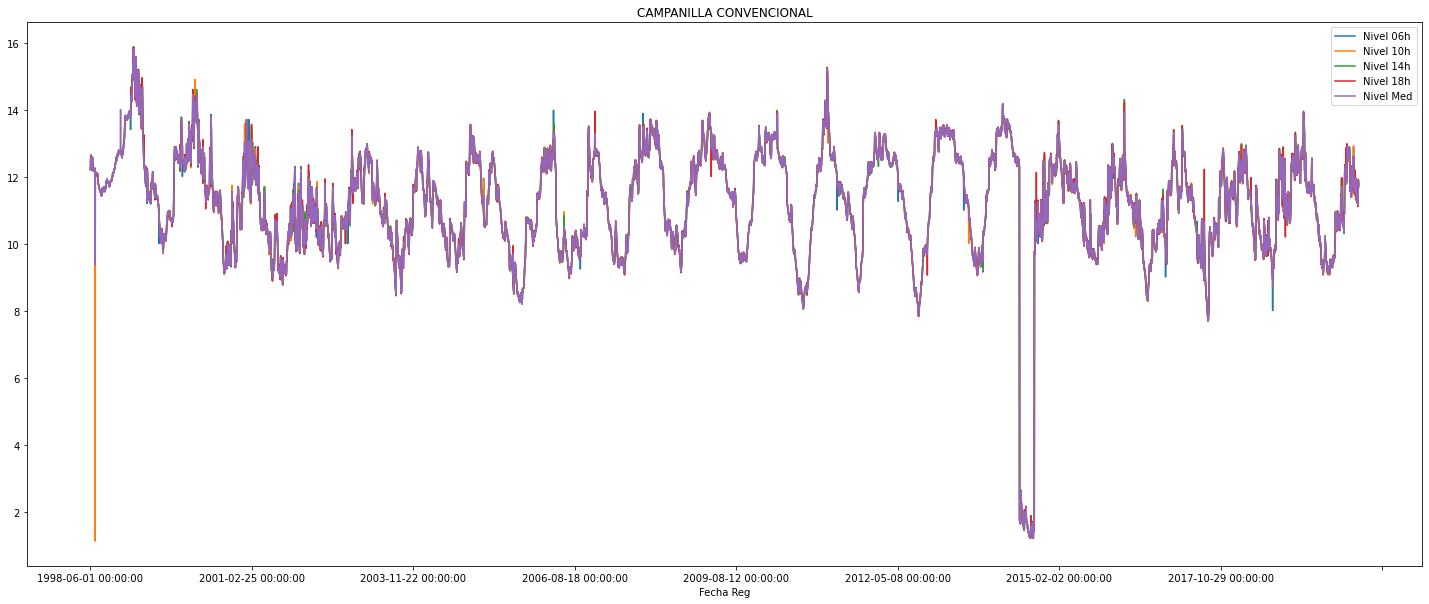

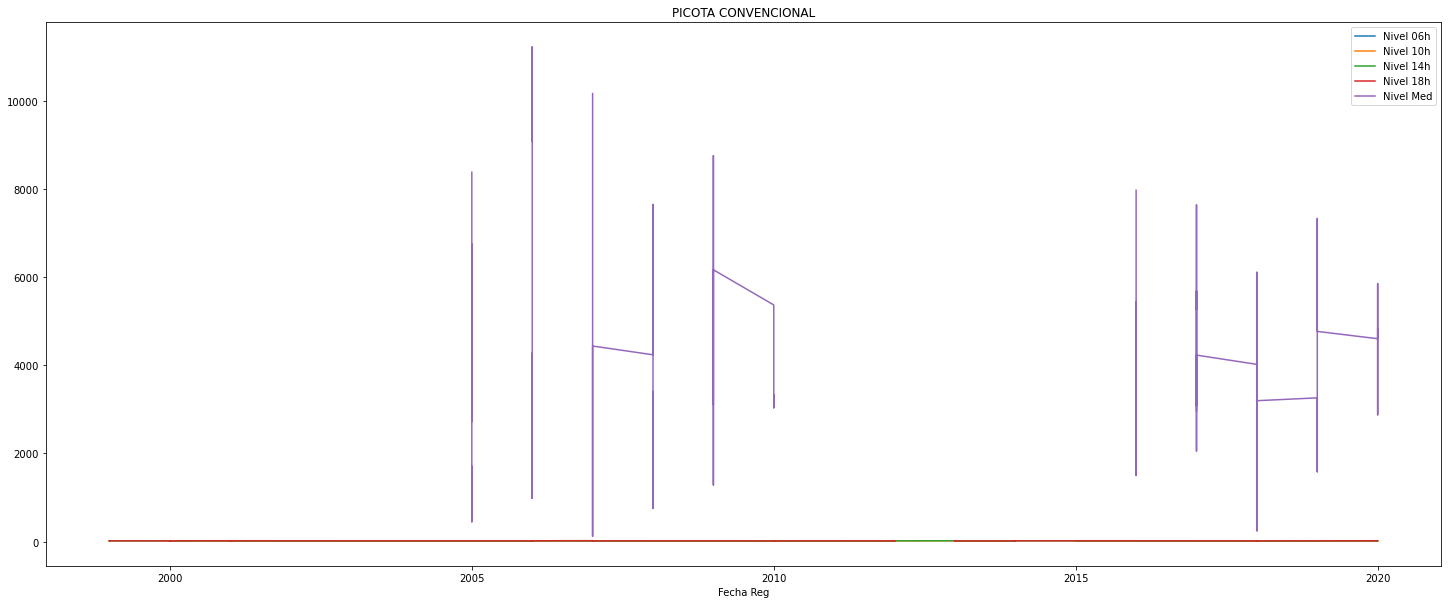

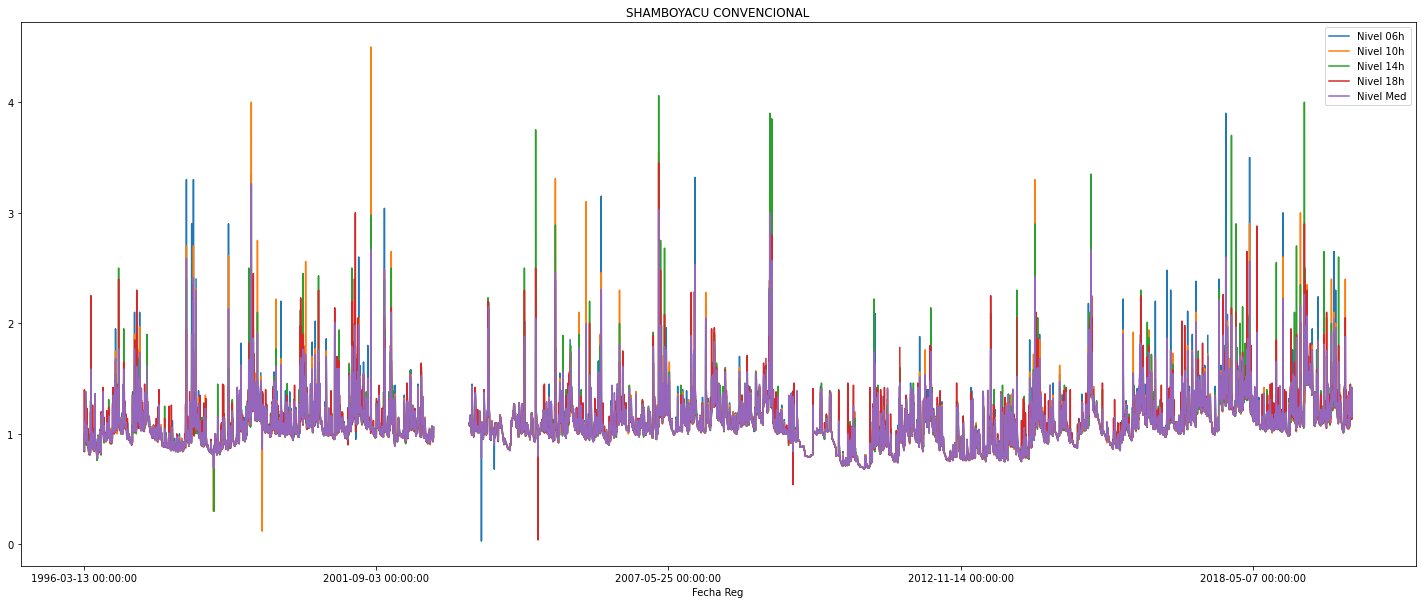

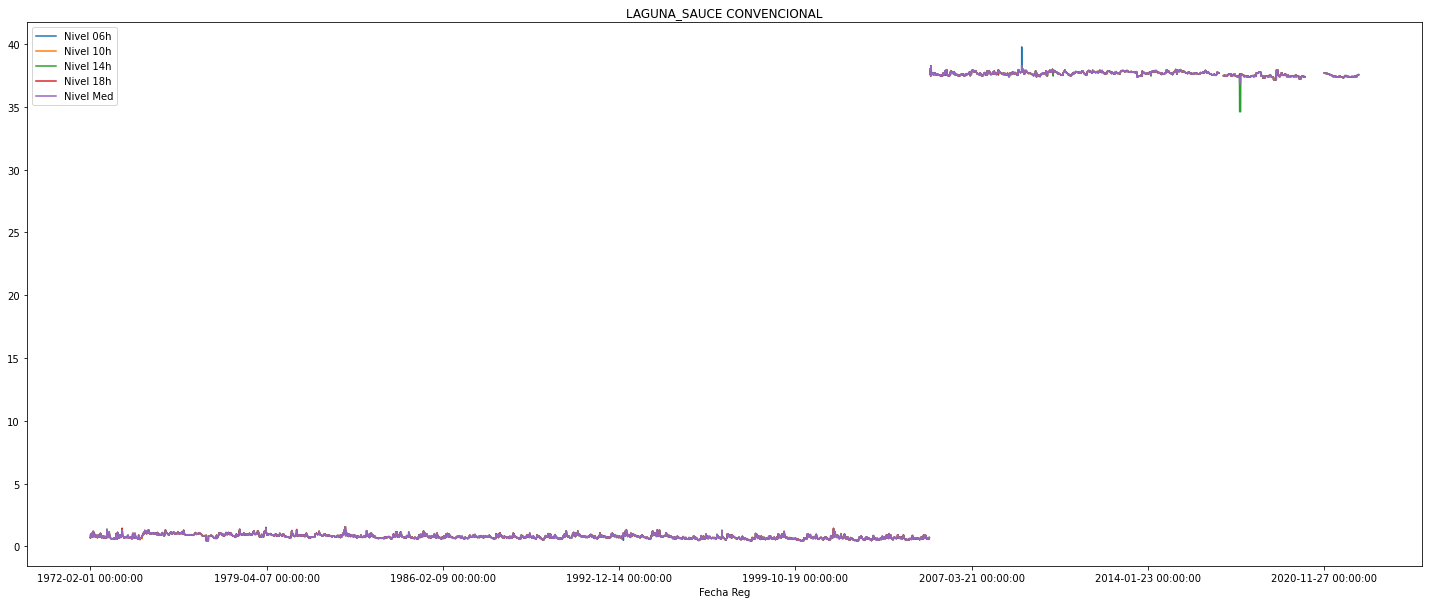

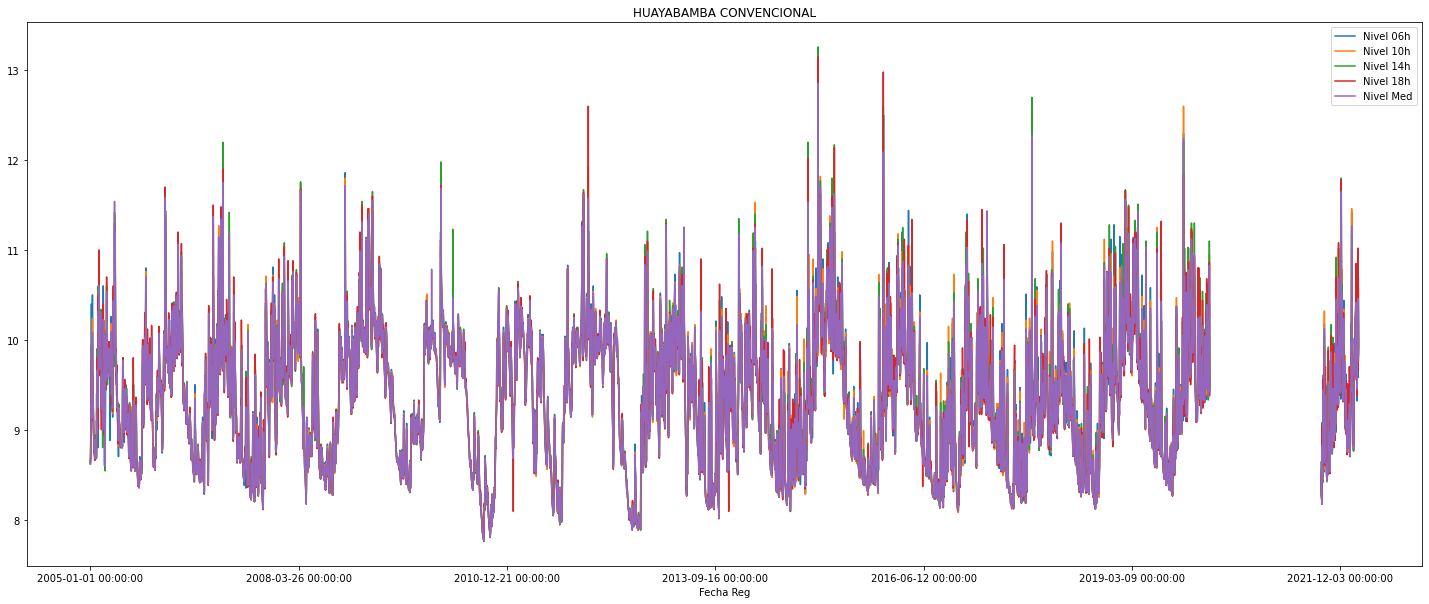

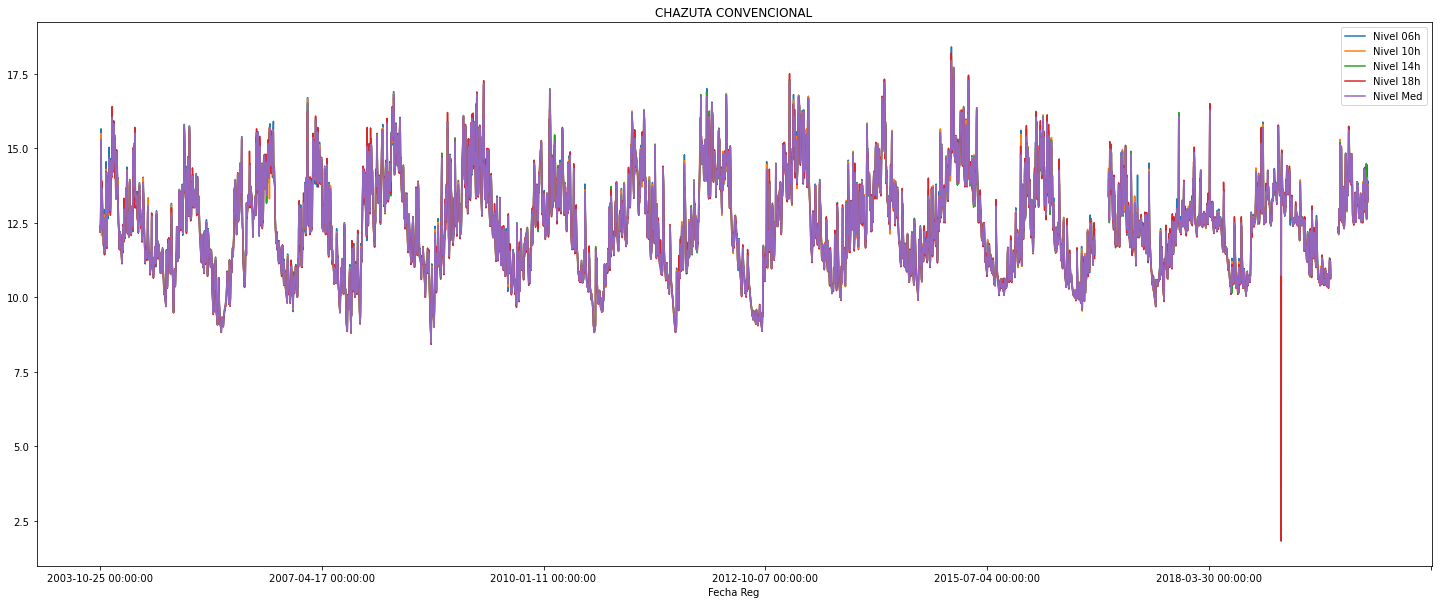

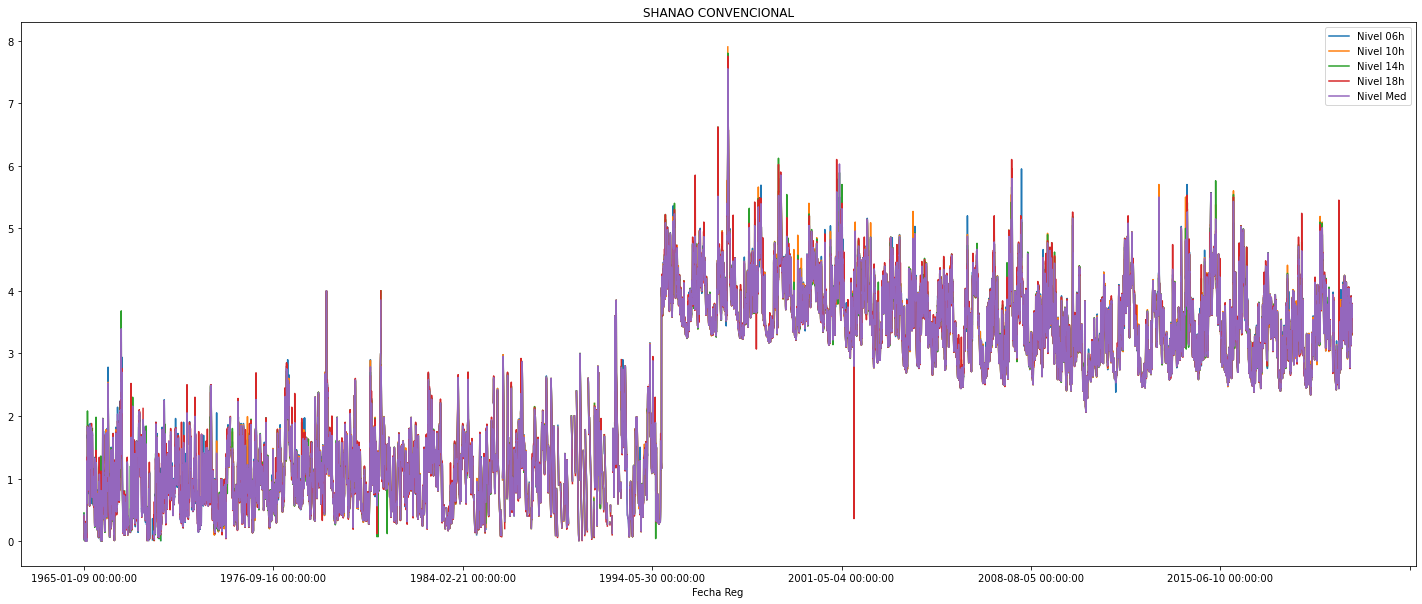

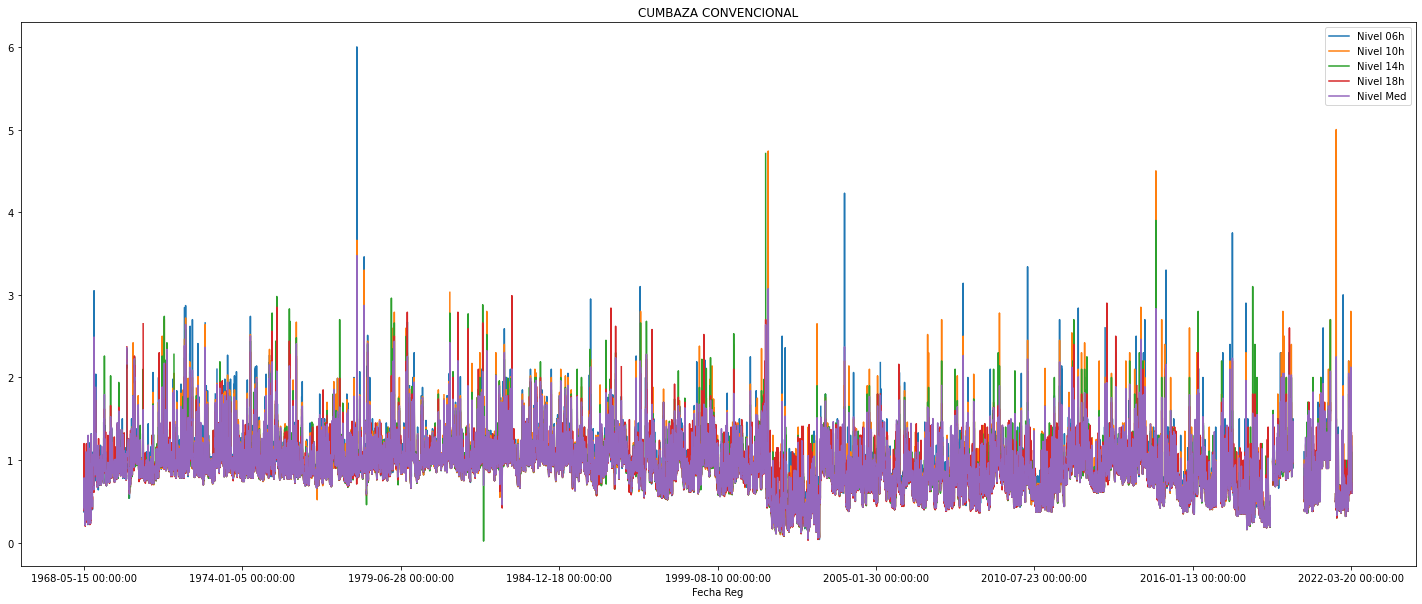

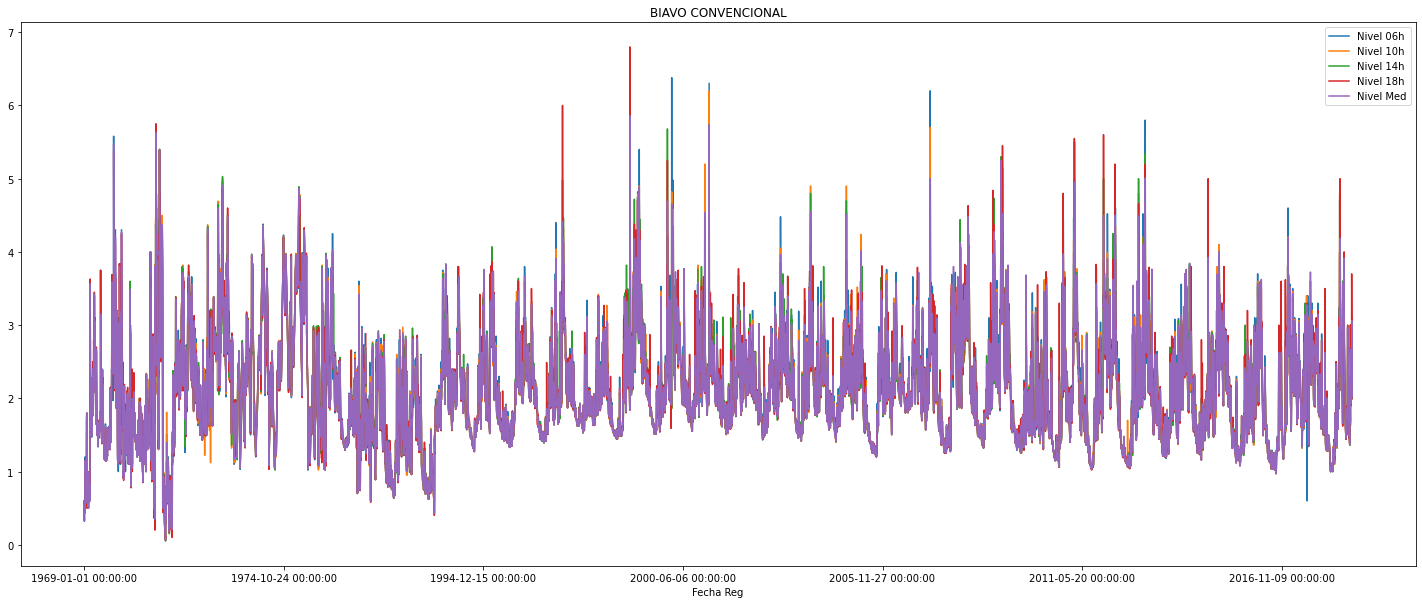

In [240]:
DZ9=Estacion_convencional.estaciones_por_dz(9)
Estacion_convencional.plot_dz_niveles()

In [70]:
#Estacion_convencional.stats_dz_niveles()

In [241]:
Estadisticos=pd.concat(Estacion_convencional.max_historic_and_previous())

PICOTA CONVENCIONALtiene menos de dos años de registro [1970]


In [242]:
Estadisticos.head(20)

Estaciones  Año de Inicio  Año de Fin  \
Nivel 06h    CAMPANILLA CONVENCIONAL Nivel 06h           1998        2020   
Nivel 10h    CAMPANILLA CONVENCIONAL Nivel 10h           1998        2020   
Nivel 14h    CAMPANILLA CONVENCIONAL Nivel 14h           1998        2020   
Nivel 18h    CAMPANILLA CONVENCIONAL Nivel 18h           1998        2020   
Nivel Med    CAMPANILLA CONVENCIONAL Nivel Med           1998        2020   
Nivel 06h    SHAMBOYACU CONVENCIONAL Nivel 06h           1996        2020   
Nivel 10h    SHAMBOYACU CONVENCIONAL Nivel 10h           1996        2020   
Nivel 14h    SHAMBOYACU CONVENCIONAL Nivel 14h           1996        2020   
Nivel 18h    SHAMBOYACU CONVENCIONAL Nivel 18h           1996        2020   
Nivel Med    SHAMBOYACU CONVENCIONAL Nivel Med           1996        2020   
Nivel 06h  LAGUNA_SAUCE CONVENCIONAL Nivel 06h           1972        2022   
Nivel 10h  LAGUNA_SAUCE CONVENCIONAL Nivel 10h           1972        2022   
Nivel 14h  LAGUNA_SAUCE CONVENCIONAL Nivel 14h           1972        2022   
Nivel 18h  LAGUNA_SAUCE CONVENCIONAL Nivel 18h           1972        2022   
Nivel Med  LAGUNA_SAUCE CONVENCIONAL Nivel Med           1972        2022   
Nivel 06h    HUAYABAMBA CONVENCIONAL Nivel 06h           2005        2022   
Nivel 10h    HUAYABAMBA CONVENCIONAL Nivel 10h           2005        2022   
Nivel 14h    HUAYABAMBA CONVENCIONAL Nivel 14h           2005        2022   
Nivel 18h    HUAYABAMBA CONVENCIONAL Nivel 18h           2005        2022   
Nivel Med    HUAYABAMBA CONVENCIONAL Nivel Med           2005        2022   

           max año previo  max historico  max año previo estiaje  \
Nivel 06h         13.8800        15.8200                 11.4000   
Nivel 10h         13.8500        15.8700                 11.4000   
Nivel 14h         13.9500        15.8700                 11.4000   
Nivel 18h         13.9200        15.8500                 11.4000   
Nivel Med         13.8825        15.8225                 11.4000   
Nivel 06h          2.6500         3.9000                  2.2400   
Nivel 10h          3.0000         4.5000                  2.4500   
Nivel 14h          4.0000         4.0600                  2.6500   
Nivel 18h          2.9000         3.4500                  2.1000   
Nivel Med          2.2600         3.2625                  1.8425   
Nivel 06h         37.6500        39.7600                 37.4700   
Nivel 10h         37.6500        38.2600                 37.4700   
Nivel 14h         37.6500        38.2300                 37.4700   
Nivel 18h         37.6500        38.2500                 37.4700   
Nivel Med         37.6500        38.2600                 37.4700   
Nivel 06h         11.3000        12.5000                 10.1800   
Nivel 10h         11.7200        12.9000                 10.3200   
Nivel 14h         11.8000        13.2600                 10.0600   
Nivel 18h         11.7800        13.1500                  9.9400   
Nivel Med         11.6500        12.8525                 10.1250   

           max año previo avenida  max año historico estiaje  \
Nivel 06h                 13.8800                    13.8500   
Nivel 10h                 13.8500                    13.7800   
Nivel 14h                 13.9500                    13.7500   
Nivel 18h                 13.9200                    13.7500   
Nivel Med                 13.8825                    13.7825   
Nivel 06h                  1.7600                     2.4800   
Nivel 10h                  3.0000                     4.5000   
Nivel 14h                  4.0000                     3.7500   
Nivel 18h                  2.9000                     2.8800   
Nivel Med                  2.2600                     2.6650   
Nivel 06h                 37.6500                    37.8800   
Nivel 10h                 37.6500                    37.8800   
Nivel 14h                 37.6500                    37.8800   
Nivel 18h                 37.6500                    37.8800   
Nivel Med                 37.

# Estacione ubicadas en cuencas especificas

In [73]:
DZ4_cuenca_estaciones,DZ4_cuencas=Estacion_convencional.estaciones_por_cuenca_dz(4)
DZ9_cuenca_estaciones,DZ9_cuencas=Estacion_convencional.estaciones_por_cuenca_dz(9)

In [74]:
maestro =Estacion_convencional.get_Maestro()
mapa=folium.Map(location=[maestro.LATITUD.mean(),maestro.LONGITUD.mean()],zoom_start=6)

In [75]:
for cuenca in DZ4_cuenca_estaciones:
    filtro=maestro[maestro['CODIGO'].isin(DZ4_cuenca_estaciones[cuenca])]
    gauge_stations(filtro,cuencas_shp,mapa,cuenca)

for cuenca in DZ9_cuenca_estaciones:
    filtro=maestro[maestro['CODIGO'].isin(DZ9_cuenca_estaciones[cuenca])]
    gauge_stations(filtro,cuencas_shp,mapa,cuenca)

In [76]:
mapa

# Busqueda de atipicos 

In [106]:
cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h','Nivel Med']
Estaciones=DZ4_cuenca_estaciones['Cuenca Rímac']
outlier_dict={}
for k,df in enumerate(DZ4_cuencas['Cuenca Rímac']):

    Q1 = df['Nivel 10h'].quantile(0.25)
    Q3 = df['Nivel 10h'].quantile(0.75)
    IQR = Q3 - Q1

    outlier_upper=Q3 + 1.5 * IQR
    index_out=df[df['Nivel 10h']>outlier_upper].index.tolist()
    dates_out=df.loc[index_out,'Fecha Reg']
    outlier_dict[Estaciones[k]]=dates_out

In [107]:
outlaiers_df=pd.DataFrame(outlier_dict)

In [110]:
outlaiers_df[outlaiers_df.isnull().sum(axis=1)<=5]

202903 202902               202904               202905  \
1133                   NaN    NaN                  NaN  1976-04-07 00:00:00   
1919                   NaN    NaN  1994-03-05 00:00:00                  NaN   
1920                   NaN    NaN  1994-03-06 00:00:00                  NaN   
1978   1993-02-06 00:00:00    NaN                  NaN                  NaN   
1984   1993-02-12 00:00:00    NaN                  NaN                  NaN   
...                    ...    ...                  ...                  ...   
10404  2016-04-02 00:00:00    NaN                  NaN  2001-10-25 00:00:00   
10405  2016-04-03 00:00:00    NaN                  NaN  2001-10-26 00:00:00   
10411  2016-04-09 00:00:00    NaN                  NaN  2001-11-01 00:00:00   
10418  2016-04-16 00:00:00    NaN                  NaN  2001-11-08 00:00:00   
11131  2018-03-30 00:00:00    NaN                  NaN                  NaN   

                    202906 202910               202930  
1133   1976-02-08 00:00:00    NaN                  NaN  
1919                   NaN    NaN  1993-02-04 00:00:00  
1920                   NaN    NaN  1993-02-05 00:00:00  
1978                   NaN    NaN  1993-04-04 00:00:00  
1984                   NaN    NaN  1993-04-10 00:00:00  
...                    ...    ...                  ...  
10404                  NaN    NaN                  NaN  
10405                  NaN    NaN                  NaN  
10411                  NaN    NaN                  NaN  
10418                  NaN    NaN                  NaN  
11131                  NaN    NaN  2018-11-25 00:00:00  

[105 rows x 7 columns]

In [112]:
ff=outlaiers_df[outlaiers_df.isnull().sum(axis=1)>=6]

In [121]:
elements_to_erase=find_index_row(df=DZ4_cuencas['Cuenca Rímac'][0],col='Fecha Reg',values=ff['202903'].dropna())

DZ4_cuencas['Cuenca Rímac'][0].loc[elements_to_erase,:]

Codigo Estacion            Fecha Reg   ano  mes  dia  Nivel 06h  \
145    202903  AUTISHA  1988-01-31 00:00:00  1988  ENE   31       1.40   
146    202903  AUTISHA  1988-02-01 00:00:00  1988  FEB    1       1.60   
147    202903  AUTISHA  1988-02-02 00:00:00  1988  FEB    2       1.70   
148    202903  AUTISHA  1988-02-03 00:00:00  1988  FEB    3       1.50   
149    202903  AUTISHA  1988-02-04 00:00:00  1988  FEB    4       1.75   
...       ...      ...                  ...   ...  ...  ...        ...   
11490  202903  AUTISHA  2019-03-24 00:00:00  2019  MAR   24       1.50   
11788  202903  AUTISHA  2020-01-16 00:00:00  2020  ENE   16       1.40   
11789  202903  AUTISHA  2020-01-17 00:00:00  2020  ENE   17       1.00   
11790  202903  AUTISHA  2020-01-18 00:00:00  2020  ENE   18       1.50   
11795  202903  AUTISHA  2020-01-23 00:00:00  2020  ENE   23       1.40   

       Nivel 10h  Nivel 14h  Nivel 18h  Nivel Med Caudal  
145         1.40       1.40       1.40       1.40   None  
146         1.60       1.70       1.70       1.65   None  
147         1.70       1.70       1.70       1.70   None  
148         1.50       1.50       1.50       1.50   None  
149         1.75       1.75       1.75       1.75   None  
...          ...        ...        ...        ...    ...  
11490       1.50       1.50       1.50       1.50   None  
11788       1.40       1.20       1.20       1.30   None  
11789       1.60       1.60       1.60       1.45   None  
11790       1.50       1.50       1.50       1.50   None  
11795       1.40       1.40       1.40       1.40   None  

[403 rows x 12 columns]

In [243]:
DZ9.keys()

dict_keys(['CAMPANILLA CONVENCIONAL', 'PICOTA CONVENCIONAL', 'SHAMBOYACU CONVENCIONAL', 'LAGUNA_SAUCE CONVENCIONAL', 'HUAYABAMBA CONVENCIONAL', 'CHAZUTA CONVENCIONAL', 'SHANAO CONVENCIONAL', 'CUMBAZA CONVENCIONAL', 'BIAVO CONVENCIONAL'])

In [260]:
df=DZ9['PICOTA CONVENCIONAL']

In [253]:
cols=['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h']
outlier_inter_dict={}
for col in cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    outlier_upper=Q3 + 1.5 * IQR
    index_out=df[df[col]>outlier_upper].index.tolist()
    dates_out=df.loc[index_out,'Fecha Reg']
    outlier_inter_dict[col]=dates_out

outlaiers_interno_df=pd.DataFrame(outlier_inter_dict)
outlaiers_interno_solitarios=outlaiers_interno_df[outlaiers_interno_df.isnull().sum(axis=1)>2]
'''
for col in cols:
    elements_to_erase=find_index_row(df=df,col='Fecha Reg',values=outlaiers_interno_solitarios[col].dropna())
    df.loc[elements_to_erase,col]=np.NaN
'''

"\nfor col in cols:\n    elements_to_erase=find_index_row(df=df,col='Fecha Reg',values=outlaiers_interno_solitarios[col].dropna())\n    df.loc[elements_to_erase,col]=np.NaN\n"

In [254]:
elements_to_erase=find_index_row(df=df,col='Fecha Reg',values=outlaiers_interno_solitarios['Nivel 10h'].dropna())
df.loc[elements_to_erase,:]

Empty DataFrame
Columns: [Codigo, Estacion, Fecha Reg, ano, mes, dia, Nivel 06h, Nivel 10h, Nivel 14h, Nivel 18h, Nivel Med, Caudal]
Index: []

In [255]:
elements_to_erase=find_index_row(df=df,col='Fecha Reg',values=outlaiers_interno_solitarios['Nivel 14h'].dropna())
df.loc[elements_to_erase,:]

Empty DataFrame
Columns: [Codigo, Estacion, Fecha Reg, ano, mes, dia, Nivel 06h, Nivel 10h, Nivel 14h, Nivel 18h, Nivel Med, Caudal]
Index: []

In [256]:
elements_to_erase=find_index_row(df=df,col='Fecha Reg',values=outlaiers_interno_solitarios['Nivel 18h'].dropna())
df.loc[elements_to_erase,:]

Empty DataFrame
Columns: [Codigo, Estacion, Fecha Reg, ano, mes, dia, Nivel 06h, Nivel 10h, Nivel 14h, Nivel 18h, Nivel Med, Caudal]
Index: []

In [265]:
df=clean_outliers_internos(df)

In [266]:
df.describe()

Codigo    Fecha Reg          mes          dia    Nivel 06h  \
count    7412.0  7412.000000  7412.000000  7412.000000  7409.000000   
mean   230715.0  2009.562736    15.713438    16.269949    16.266610   
std         0.0     5.861992     8.799904     0.998372     1.000431   
min    230715.0  1999.000000     1.000000    13.950000    13.960000   
25%    230715.0  2004.000000     8.000000    15.450000    15.450000   
50%    230715.0  2010.000000    16.000000    16.290000    16.280000   
75%    230715.0  2015.000000    23.000000    17.030000    17.020000   
max    230715.0  2020.000000    31.000000    19.800000    19.980000   

         Nivel 10h    Nivel 14h    Nivel 18h     Nivel Med  
count  7410.000000  7412.000000  7411.000000   3191.000000  
mean     16.274057    16.289948    16.272450   3417.914244  
std       1.010235     1.014616     0.997234   1524.165063  
min      11.360000    13.950000    13.955000    118.470000  
25%      15.450000    15.460000    15.452500   2206.796500  
50%      16.300000    16.300000    16.295000   3278.037000  
75%      17.040000    17.060000    17.027500   4397.760000  
max      19.950000    19.890000    19.892500  11216.370000

<AxesSubplot:>

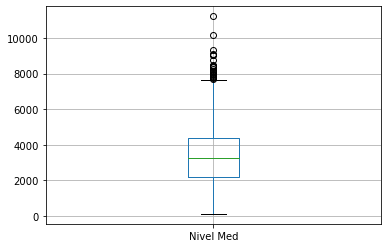

In [267]:
df[['Nivel Med']].boxplot()

In [271]:
df[['Nivel 06h','Nivel 10h','Nivel 14h','Nivel 18h']].mean(axis=1,skipna=True)

0       16.061250
1       15.855000
2       15.790625
3       15.619375
4       15.512500
          ...    
7407    17.445000
7408    17.067500
7409    17.570000
7410    17.265000
7411    16.790000
Length: 7412, dtype: float64

In [275]:
df

Codigo             Estacion  Fecha Reg  ano  mes    dia  Nivel 06h  \
0     230715  1999-12-01 00:00:00       1999  DIC    1  15.98      15.98   
1     230715  1999-12-02 00:00:00       1999  DIC    2  15.93      15.82   
2     230715  1999-12-03 00:00:00       1999  DIC    3  15.80      15.80   
3     230715  1999-12-04 00:00:00       1999  DIC    4  15.71      15.68   
4     230715  1999-12-05 00:00:00       1999  DIC    5  15.55      15.53   
...      ...                  ...        ...  ...  ...    ...        ...   
7407  230715  2020-03-12 00:00:00       2020  MAR   12  17.72      17.54   
7408  230715  2020-03-13 00:00:00       2020  MAR   13  17.12      17.09   
7409  230715  2020-03-14 00:00:00       2020  MAR   14  17.20      17.24   
7410  230715  2020-03-15 00:00:00       2020  MAR   15  17.50      17.32   
7411  230715  2020-03-16 00:00:00       2020  MAR   16  16.83      16.82   

      Nivel 10h  Nivel 14h  Nivel 18h  Nivel Med Caudal  
0         16.09      16.13    16.0450      16.06   None  
1         15.82      15.91    15.8700      15.86   None  
2         15.80      15.77    15.7925      15.79   None  
3         15.60      15.56    15.6375      15.62   None  
4         15.49      15.51    15.5200      15.51   None  
...         ...        ...        ...        ...    ...  
7407      17.40      17.34    17.5000      17.44   None  
7408      17.07      17.03    17.0800      17.07   None  
7409      17.74      17.80    17.5000      17.57   None  
7410      17.25      17.18    17.3100      17.26   None  
7411      16.79      16.75    16.8000      16.79   None  

[7412 rows x 12 columns]